In [336]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

from catboost import CatBoostRegressor

from xgboost import XGBRegressor

import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
database = '../input/data.sqlite'
conn = sqlite3.connect(database)

In [3]:
# Read whole table from database
query = """SELECT * from cleaned_data"""
res = conn.execute(query)
df = pd.read_sql_query(query, conn, index_col="index")

In [4]:
df.head()

,paper_number,cs1,cs1_mw,cs_conc1,CS_C1,CS_H1,CS_O1,cs2,cs2_mw,cs_conc2,CS_C2,CS_H2,CS_O2,cs3,cs3_mw,cs_conc3,CS_C3,CS_H3,CS_O3,reactor_type,rxt_volume,media,temp,oxygen,strain_background,strain_background_genotype,strain_background_genotype_modification,genes_modified,gene_deletion,gene_overexpression,heterologous_gene,replication_origin,codon_optimization,sensor_regulator,enzyme_redesign_evolution,protein_scaffold,dir_evo,Mod_path_opt,product_name,no_C,no_H,no_O,no_N,mw,yield,titer,rate,fermentation_time
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,9.0,92.09,2714.735585,3.0,8.0,3.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,3.0,6.00,LB,30.0,1.0,BL21 (DE3) (-fadD),"ompT, gal, dcm, lon, hsdSb, lacI, T7 RNApolyme...","[0, 0, 0, 0, 0, 1, 1, 1, 0]","accB, accC, accD, accA, tesA","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 1]","[0, 0, 0, 0, 1]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0,0,fatty acid,14.0,28.0,3.0,0.0,244.0,0.060000,0.936,0.187500,4.992
1,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.05,LB,30.0,1.0,ML103 (-fadD),"ilvG, rfb, rph, fadD","[0, 0, 0, 0]",nil,[0],[0],[0],[0],[0],[0],[0],[0],0,0,fatty acid,12.0,24.0,2.0,0.0,200.0,0.012011,1.000,0.041667,24.000
2,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.05,LB,30.0,1.0,ML103 (-fadD),"ilvG, rfb, rph, fadD","[0, 0, 0, 0]","prpE, tesAuc","[0, 0]","[1, 1]","[1, 1]","[1, 4]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",0,0,fatty acid,12.0,24.0,2.0,0.0,200.0,0.016335,1.360,0.028333,48.000
3,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.05,LB,30.0,1.0,ML103 (-fadD),"ilvG, rfb, rph, fadD","[0, 0, 0, 0]","prpE, tesAuc","[0, 0]","[1, 1]","[1, 1]","[1, 4]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",0,0,fatty acid,12.0,24.0,2.0,0.0,200.0,0.016947,1.411,0.029396,48.000
4,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.05,LB,30.0,1.0,ML103 (-fadD),"ilvG, rfb, rph, fadD","[0, 0, 0, 0]","prpE, tesArc","[0, 0]","[1, 1]","[1, 1]","[1, 4]","[0, 1]","[0, 0]","[0, 0]","[0, 0]",0,0,fatty acid,16.0,32.0,2.0,0.0,256.0,0.019818,1.650,0.068750,24.000


In [344]:
df.columns

Index(['paper_number', 'cs1', 'cs1_mw', 'cs_conc1', 'CS_C1', 'CS_H1', 'CS_O1',
       'cs2', 'cs2_mw', 'cs_conc2', 'CS_C2', 'CS_H2', 'CS_O2', 'cs3', 'cs3_mw',
       'cs_conc3', 'CS_C3', 'CS_H3', 'CS_O3', 'reactor_type', 'rxt_volume',
       'media', 'temp', 'oxygen', 'strain_background',
       'strain_background_genotype', 'strain_background_genotype_modification',
       'genes_modified', 'gene_deletion', 'gene_overexpression',
       'heterologous_gene', 'replication_origin', 'codon_optimization',
       'sensor_regulator', 'enzyme_redesign_evolution', 'protein_scaffold',
       'dir_evo', 'Mod_path_opt', 'product_name', 'no_C', 'no_H', 'no_O',
       'no_N', 'mw', 'yield', 'titer', 'rate', 'fermentation_time'],
      dtype='object')

In [5]:
numerical_columns = df.select_dtypes(include=['number'])
numerical_columns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 769 entries, 0 to 1207
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   paper_number       769 non-null    int64  
 1   cs1                769 non-null    float64
 2   cs1_mw             769 non-null    float64
 3   cs_conc1           769 non-null    float64
 4   CS_C1              769 non-null    float64
 5   CS_H1              769 non-null    float64
 6   CS_O1              769 non-null    float64
 7   cs2                769 non-null    int64  
 8   cs2_mw             769 non-null    float64
 9   cs_conc2           769 non-null    float64
 10  CS_C2              769 non-null    float64
 11  CS_H2              769 non-null    float64
 12  CS_O2              769 non-null    float64
 13  cs3                769 non-null    int64  
 14  cs3_mw             769 non-null    float64
 15  cs_conc3           769 non-null    float64
 16  CS_C3              769 non-nul

<Axes: >

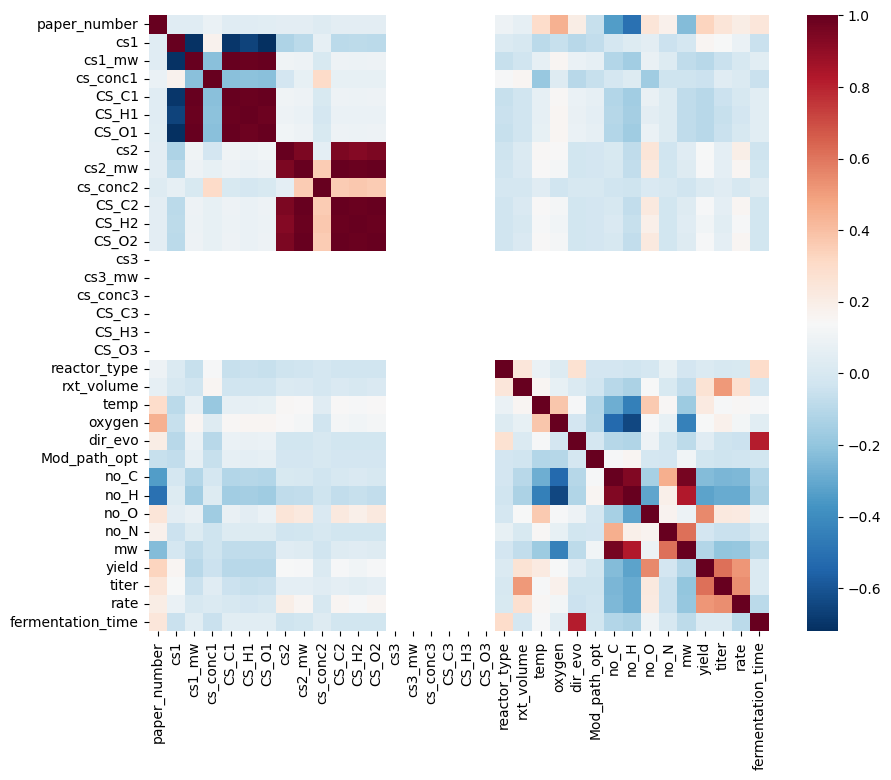

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_columns.corr(), cmap='RdBu_r')

### Preprocessing

1. Drop columns for 3rd carbon source
2. Change strings of lists back to lists
3. One-hot encode reactor type, media, oxygen (Should keep in pipeline)
4. Leave strain_background alone. Most likely ignore given too many type 
5. Create / check 'corpus' for strain_background_genotype and multilabel binarize (Should keep in pipeline)
6. Create / check 'genes_modified' for strain_background_genotype and multilabel binarize (Should keep in pipeline)
7. One-hot encode product_name (Too many to one hot encode --> create high dimensionality)

### Feature Engineering

Categorize product e.g. sugar, fatty acid, alcohol, amino acid

In [7]:
df_1 = df.copy()
third_carbon_columns = ['cs3', 'cs3_mw', 'cs_conc3', 'CS_C3', 'CS_H3', 'CS_O3']
df_1.drop(columns=third_carbon_columns, axis=1, inplace=True)

In [8]:
def eval_stringlist(string_list):
    """ Function to convert string to lists and handle errors if any
    Parameter:
    _________
    string_list: str
        string value in each cell to be converted back into list
    
    Returns:
    _______
    
    list of numbers corresponding to the genes involved OR None 
    """
    try:
        return eval(string_list)
    except (SyntaxError, ValueError):
        return None


In [9]:
stringlist_columns = ['strain_background_genotype_modification', 'gene_deletion', 'gene_overexpression', 'heterologous_gene', 'replication_origin', 'codon_optimization','sensor_regulator', 'enzyme_redesign_evolution', 'protein_scaffold']

for column in stringlist_columns:
    df_1[column] = df_1[column].apply(eval_stringlist)

In [10]:
# Function to convert strain_background_genotype and genes_modified from strings to lists of strings

def create_gene_list(df, feature):
    for index, row in df.iterrows():
        df.at[index, feature] = row[feature].split(", ")

In [11]:
create_gene_list(df_1, "strain_background_genotype")

In [12]:
create_gene_list(df_1, "genes_modified")

In [13]:
df_1['background_genotype_num'] = df_1["strain_background_genotype"].apply(len)

In [14]:
# Function to count genes_modified and ignore nil if present

def len_genes_modified(list):
    length = len(list)
    if length > 1:
        return length
    if length == 1:
        if list[0] == 'nil':
            return 0
        else:
            return 1
    

In [15]:
df_1['genes_modified_num'] = df_1['genes_modified'].apply(len_genes_modified)

In [16]:
# columns to sum up the list of numbers corresponding to the genes mentioned
gene_num_columns = ['strain_background_genotype_modification', 'gene_overexpression', 'heterologous_gene', 'replication_origin', 'codon_optimization','sensor_regulator', 'enzyme_redesign_evolution']

for column in gene_num_columns:
    new_column = column + '_num'
    df_1[new_column] = df_1[column].apply(sum)



In [17]:
df_1.describe()

,paper_number,cs1,cs1_mw,cs_conc1,CS_C1,CS_H1,CS_O1,cs2,cs2_mw,cs_conc2,CS_C2,CS_H2,CS_O2,reactor_type,rxt_volume,temp,oxygen,dir_evo,Mod_path_opt,no_C,no_H,no_O,no_N,mw,yield,titer,rate,fermentation_time,background_genotype_num,genes_modified_num,strain_background_genotype_modification_num,gene_overexpression_num,heterologous_gene_num,replication_origin_num,codon_optimization_num,sensor_regulator_num,enzyme_redesign_evolution_num
count,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000
mean,44.555267,3.937581,155.773726,182.263158,5.172952,10.894668,5.166450,0.288687,3.549168,3.552612,0.118336,0.211964,0.118336,1.068921,0.340535,33.755527,1.842653,0.019506,0.010403,7.880364,15.384915,2.133940,0.083225,147.170633,0.219121,3.800136,0.105613,69.768670,8.176853,3.036411,0.867360,3.011704,1.547464,11.453836,0.357607,0.007802,0.044213
std,31.947791,4.200540,41.620739,241.655278,1.431599,2.005354,1.402516,1.604807,20.201935,81.303939,0.673369,1.282113,0.673369,0.344879,0.944592,3.510779,0.801984,0.138385,0.101530,6.595946,11.054556,1.295628,0.513710,99.399551,0.243738,7.745618,0.219205,170.816248,4.166138,3.025280,1.471284,3.042429,1.791370,19.256040,0.646161,0.088043,0.223888
min,1.000000,1.000000,92.090000,5.472907,3.000000,8.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.003000,25.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,1.000000,92.090000,99.913408,3.000000,8.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.012000,30.000000,1.000000,0.000000,0.000000,4.000000,6.000000,1.000000,0.000000,74.000000,0.054048,0.250000,0.005556,24.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,1.000000,180.160000,111.012433,6.000000,12.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.050000,37.000000,2.000000,0.000000,0.000000,4.000000,10.000000,2.000000,0.000000,118.000000,0.133648,1.320000,0.033951,40.000000,8.000000,2.000000,0.000000,2.000000,1.000000,5.000000,0.000000,0.000000,0.000000
75%,70.000000,9.000000,180.160000,199.822380,6.000000,12.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.314546,37.000000,3.000000,0.000000,0.000000,13.000000,28.000000,3.000000,0.000000,200.000000,0.264456,4.410660,0.095304,50.000000,11.000000,5.000000,1.000000,5.000000,2.000000,12.000000,1.000000,0.000000,0.000000
max,109.000000,15.000000,342.297000,2714.735585,12.000000,22.000000,11.000000,12.000000,180.160000,2251.950000,6.000000,12.000000,6.000000,3.000000,8.000000,40.000000,3.000000,1.000000,1.000000,40.000000,56.000000,5.000000,4.000000,641.610000,1.134111,120.709018,2.443295,1440.000000,20.000000,15.000000,8.000000,15.000000,8.000000,100.000000,4.000000,1.000000,2.000000


In [18]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 769 entries, 0 to 1207
Data columns (total 51 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   paper_number                                 769 non-null    int64  
 1   cs1                                          769 non-null    float64
 2   cs1_mw                                       769 non-null    float64
 3   cs_conc1                                     769 non-null    float64
 4   CS_C1                                        769 non-null    float64
 5   CS_H1                                        769 non-null    float64
 6   CS_O1                                        769 non-null    float64
 7   cs2                                          769 non-null    int64  
 8   cs2_mw                                       769 non-null    float64
 9   cs_conc2                                     769 non-null    float64
 10  CS_C2 

In [19]:
numerical_columns_1 = df_1.select_dtypes(include='number')

<Axes: >

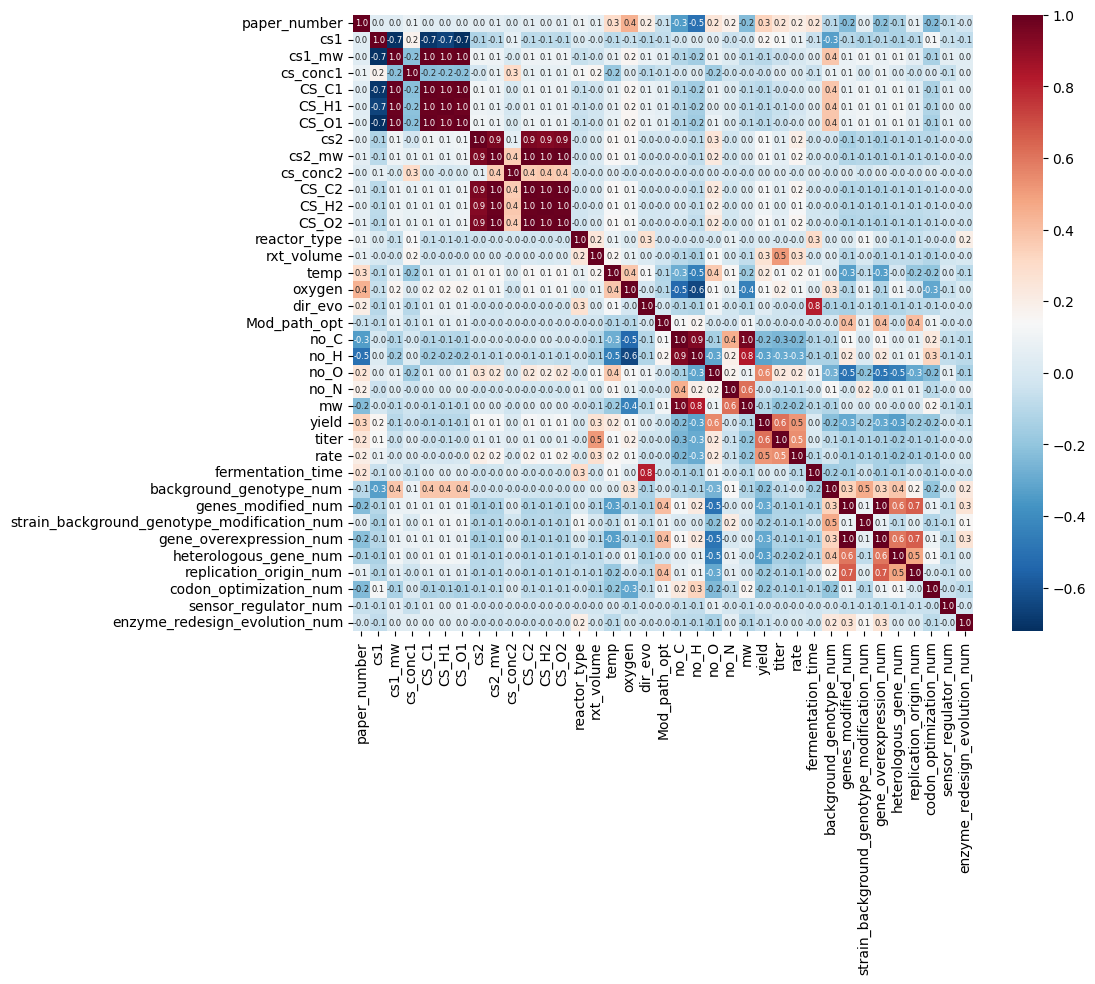

In [38]:
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_columns_1.corr(), cmap='RdBu_r', annot=True, fmt='.1f', annot_kws={'size': 6})

In [40]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 769 entries, 0 to 1207
Data columns (total 51 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   paper_number                                 769 non-null    int64  
 1   cs1                                          769 non-null    float64
 2   cs1_mw                                       769 non-null    float64
 3   cs_conc1                                     769 non-null    float64
 4   CS_C1                                        769 non-null    float64
 5   CS_H1                                        769 non-null    float64
 6   CS_O1                                        769 non-null    float64
 7   cs2                                          769 non-null    int64  
 8   cs2_mw                                       769 non-null    float64
 9   cs_conc2                                     769 non-null    float64
 10  CS_C2 

In [21]:
df_1.head()

,paper_number,cs1,cs1_mw,cs_conc1,CS_C1,CS_H1,CS_O1,cs2,cs2_mw,cs_conc2,CS_C2,CS_H2,CS_O2,reactor_type,rxt_volume,media,temp,oxygen,strain_background,strain_background_genotype,strain_background_genotype_modification,genes_modified,gene_deletion,gene_overexpression,heterologous_gene,replication_origin,codon_optimization,sensor_regulator,enzyme_redesign_evolution,protein_scaffold,dir_evo,Mod_path_opt,product_name,no_C,no_H,no_O,no_N,mw,yield,titer,rate,fermentation_time,background_genotype_num,genes_modified_num,strain_background_genotype_modification_num,gene_overexpression_num,heterologous_gene_num,replication_origin_num,codon_optimization_num,sensor_regulator_num,enzyme_redesign_evolution_num
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,9.0,92.09,2714.735585,3.0,8.0,3.0,0,0.0,0.0,0.0,0.0,0.0,3.0,6.00,LB,30.0,1.0,BL21 (DE3) (-fadD),"[ompT, gal, dcm, lon, hsdSb, lacI, T7 RNApolym...","[0, 0, 0, 0, 0, 1, 1, 1, 0]","[accB, accC, accD, accA, tesA]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 1]","[0, 0, 0, 0, 1]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0,0,fatty acid,14.0,28.0,3.0,0.0,244.0,0.060000,0.936,0.187500,4.992,9,5,3,5,1,1,0,0,0
1,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.05,LB,30.0,1.0,ML103 (-fadD),"[ilvG, rfb, rph, fadD]","[0, 0, 0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],0,0,fatty acid,12.0,24.0,2.0,0.0,200.0,0.012011,1.000,0.041667,24.000,4,0,0,0,0,0,0,0,0
2,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.05,LB,30.0,1.0,ML103 (-fadD),"[ilvG, rfb, rph, fadD]","[0, 0, 0, 0]","[prpE, tesAuc]","[0, 0]","[1, 1]","[1, 1]","[1, 4]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",0,0,fatty acid,12.0,24.0,2.0,0.0,200.0,0.016335,1.360,0.028333,48.000,4,2,0,2,2,5,0,0,0
3,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.05,LB,30.0,1.0,ML103 (-fadD),"[ilvG, rfb, rph, fadD]","[0, 0, 0, 0]","[prpE, tesAuc]","[0, 0]","[1, 1]","[1, 1]","[1, 4]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",0,0,fatty acid,12.0,24.0,2.0,0.0,200.0,0.016947,1.411,0.029396,48.000,4,2,0,2,2,5,0,0,0
4,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.05,LB,30.0,1.0,ML103 (-fadD),"[ilvG, rfb, rph, fadD]","[0, 0, 0, 0]","[prpE, tesArc]","[0, 0]","[1, 1]","[1, 1]","[1, 4]","[0, 1]","[0, 0]","[0, 0]","[0, 0]",0,0,fatty acid,16.0,32.0,2.0,0.0,256.0,0.019818,1.650,0.068750,24.000,4,2,0,2,2,5,1,0,0


In [32]:
df_2 = pd.get_dummies(df_1, columns=['reactor_type'], prefix='reactor_type', dtype=int)
df_2.head()

,paper_number,cs1,cs1_mw,cs_conc1,CS_C1,CS_H1,CS_O1,cs2,cs2_mw,cs_conc2,CS_C2,CS_H2,CS_O2,rxt_volume,media,temp,oxygen,strain_background,strain_background_genotype,strain_background_genotype_modification,genes_modified,gene_deletion,gene_overexpression,heterologous_gene,replication_origin,codon_optimization,sensor_regulator,enzyme_redesign_evolution,protein_scaffold,dir_evo,Mod_path_opt,product_name,no_C,no_H,no_O,no_N,mw,yield,titer,rate,fermentation_time,background_genotype_num,genes_modified_num,strain_background_genotype_modification_num,gene_overexpression_num,heterologous_gene_num,replication_origin_num,codon_optimization_num,sensor_regulator_num,enzyme_redesign_evolution_num,reactor_type_1.0,reactor_type_2.0,reactor_type_3.0
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,9.0,92.09,2714.735585,3.0,8.0,3.0,0,0.0,0.0,0.0,0.0,0.0,6.00,LB,30.0,1.0,BL21 (DE3) (-fadD),"[ompT, gal, dcm, lon, hsdSb, lacI, T7 RNApolym...","[0, 0, 0, 0, 0, 1, 1, 1, 0]","[accB, accC, accD, accA, tesA]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 1]","[0, 0, 0, 0, 1]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0,0,fatty acid,14.0,28.0,3.0,0.0,244.0,0.060000,0.936,0.187500,4.992,9,5,3,5,1,1,0,0,0,0,0,1
1,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.05,LB,30.0,1.0,ML103 (-fadD),"[ilvG, rfb, rph, fadD]","[0, 0, 0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],0,0,fatty acid,12.0,24.0,2.0,0.0,200.0,0.012011,1.000,0.041667,24.000,4,0,0,0,0,0,0,0,0,1,0,0
2,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.05,LB,30.0,1.0,ML103 (-fadD),"[ilvG, rfb, rph, fadD]","[0, 0, 0, 0]","[prpE, tesAuc]","[0, 0]","[1, 1]","[1, 1]","[1, 4]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",0,0,fatty acid,12.0,24.0,2.0,0.0,200.0,0.016335,1.360,0.028333,48.000,4,2,0,2,2,5,0,0,0,1,0,0
3,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.05,LB,30.0,1.0,ML103 (-fadD),"[ilvG, rfb, rph, fadD]","[0, 0, 0, 0]","[prpE, tesAuc]","[0, 0]","[1, 1]","[1, 1]","[1, 4]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",0,0,fatty acid,12.0,24.0,2.0,0.0,200.0,0.016947,1.411,0.029396,48.000,4,2,0,2,2,5,0,0,0,1,0,0
4,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.05,LB,30.0,1.0,ML103 (-fadD),"[ilvG, rfb, rph, fadD]","[0, 0, 0, 0]","[prpE, tesArc]","[0, 0]","[1, 1]","[1, 1]","[1, 4]","[0, 1]","[0, 0]","[0, 0]","[0, 0]",0,0,fatty acid,16.0,32.0,2.0,0.0,256.0,0.019818,1.650,0.068750,24.000,4,2,0,2,2,5,1,0,0,1,0,0


In [34]:
df_3 = pd.get_dummies(df_2, columns=['media'], prefix='media', dtype=int)
df_3.head()

,paper_number,cs1,cs1_mw,cs_conc1,CS_C1,CS_H1,CS_O1,cs2,cs2_mw,cs_conc2,CS_C2,CS_H2,CS_O2,rxt_volume,temp,oxygen,strain_background,strain_background_genotype,strain_background_genotype_modification,genes_modified,gene_deletion,gene_overexpression,heterologous_gene,replication_origin,codon_optimization,sensor_regulator,enzyme_redesign_evolution,protein_scaffold,dir_evo,Mod_path_opt,product_name,no_C,no_H,no_O,no_N,mw,yield,titer,rate,fermentation_time,background_genotype_num,genes_modified_num,strain_background_genotype_modification_num,gene_overexpression_num,heterologous_gene_num,replication_origin_num,codon_optimization_num,sensor_regulator_num,enzyme_redesign_evolution_num,reactor_type_1.0,reactor_type_2.0,reactor_type_3.0,media_LB,media_M9,media_MOPS,media_NBS,media_RICH,media_TB,media_YE
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,9.0,92.09,2714.735585,3.0,8.0,3.0,0,0.0,0.0,0.0,0.0,0.0,6.00,30.0,1.0,BL21 (DE3) (-fadD),"[ompT, gal, dcm, lon, hsdSb, lacI, T7 RNApolym...","[0, 0, 0, 0, 0, 1, 1, 1, 0]","[accB, accC, accD, accA, tesA]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 1]","[0, 0, 0, 0, 1]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0,0,fatty acid,14.0,28.0,3.0,0.0,244.0,0.060000,0.936,0.187500,4.992,9,5,3,5,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0
1,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.05,30.0,1.0,ML103 (-fadD),"[ilvG, rfb, rph, fadD]","[0, 0, 0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],0,0,fatty acid,12.0,24.0,2.0,0.0,200.0,0.012011,1.000,0.041667,24.000,4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.05,30.0,1.0,ML103 (-fadD),"[ilvG, rfb, rph, fadD]","[0, 0, 0, 0]","[prpE, tesAuc]","[0, 0]","[1, 1]","[1, 1]","[1, 4]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",0,0,fatty acid,12.0,24.0,2.0,0.0,200.0,0.016335,1.360,0.028333,48.000,4,2,0,2,2,5,0,0,0,1,0,0,1,0,0,0,0,0,0
3,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.05,30.0,1.0,ML103 (-fadD),"[ilvG, rfb, rph, fadD]","[0, 0, 0, 0]","[prpE, tesAuc]","[0, 0]","[1, 1]","[1, 1]","[1, 4]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",0,0,fatty acid,12.0,24.0,2.0,0.0,200.0,0.016947,1.411,0.029396,48.000,4,2,0,2,2,5,0,0,0,1,0,0,1,0,0,0,0,0,0
4,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.05,30.0,1.0,ML103 (-fadD),"[ilvG, rfb, rph, fadD]","[0, 0, 0, 0]","[prpE, tesArc]","[0, 0]","[1, 1]","[1, 1]","[1, 4]","[0, 1]","[0, 0]","[0, 0]","[0, 0]",0,0,fatty acid,16.0,32.0,2.0,0.0,256.0,0.019818,1.650,0.068750,24.000,4,2,0,2,2,5,1,0,0,1,0,0,1,0,0,0,0,0,0


In [35]:
df_4 = pd.get_dummies(df_3, columns=['oxygen'], prefix='oxygen', dtype=int)
df_4.head()

,paper_number,cs1,cs1_mw,cs_conc1,CS_C1,CS_H1,CS_O1,cs2,cs2_mw,cs_conc2,CS_C2,CS_H2,CS_O2,rxt_volume,temp,strain_background,strain_background_genotype,strain_background_genotype_modification,genes_modified,gene_deletion,gene_overexpression,heterologous_gene,replication_origin,codon_optimization,sensor_regulator,enzyme_redesign_evolution,protein_scaffold,dir_evo,Mod_path_opt,product_name,no_C,no_H,no_O,no_N,mw,yield,titer,rate,fermentation_time,background_genotype_num,genes_modified_num,strain_background_genotype_modification_num,gene_overexpression_num,heterologous_gene_num,replication_origin_num,codon_optimization_num,sensor_regulator_num,enzyme_redesign_evolution_num,reactor_type_1.0,reactor_type_2.0,reactor_type_3.0,media_LB,media_M9,media_MOPS,media_NBS,media_RICH,media_TB,media_YE,oxygen_1.0,oxygen_2.0,oxygen_3.0
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,9.0,92.09,2714.735585,3.0,8.0,3.0,0,0.0,0.0,0.0,0.0,0.0,6.00,30.0,BL21 (DE3) (-fadD),"[ompT, gal, dcm, lon, hsdSb, lacI, T7 RNApolym...","[0, 0, 0, 0, 0, 1, 1, 1, 0]","[accB, accC, accD, accA, tesA]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 1]","[0, 0, 0, 0, 1]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0,0,fatty acid,14.0,28.0,3.0,0.0,244.0,0.060000,0.936,0.187500,4.992,9,5,3,5,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0
1,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.05,30.0,ML103 (-fadD),"[ilvG, rfb, rph, fadD]","[0, 0, 0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],0,0,fatty acid,12.0,24.0,2.0,0.0,200.0,0.012011,1.000,0.041667,24.000,4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
2,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.05,30.0,ML103 (-fadD),"[ilvG, rfb, rph, fadD]","[0, 0, 0, 0]","[prpE, tesAuc]","[0, 0]","[1, 1]","[1, 1]","[1, 4]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",0,0,fatty acid,12.0,24.0,2.0,0.0,200.0,0.016335,1.360,0.028333,48.000,4,2,0,2,2,5,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
3,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.05,30.0,ML103 (-fadD),"[ilvG, rfb, rph, fadD]","[0, 0, 0, 0]","[prpE, tesAuc]","[0, 0]","[1, 1]","[1, 1]","[1, 4]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",0,0,fatty acid,12.0,24.0,2.0,0.0,200.0,0.016947,1.411,0.029396,48.000,4,2,0,2,2,5,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
4,2,1.0,180.16,83.259325,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.05,30.0,ML103 (-fadD),"[ilvG, rfb, rph, fadD]","[0, 0, 0, 0]","[prpE, tesArc]","[0, 0]","[1, 1]","[1, 1]","[1, 4]","[0, 1]","[0, 0]","[0, 0]","[0, 0]",0,0,fatty acid,16.0,32.0,2.0,0.0,256.0,0.019818,1.650,0.068750,24.000,4,2,0,2,2,5,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0


In [39]:
df_4['product_name'].value_counts()

product_name
fatty acid              140
butanol                 131
succinate               103
Isobutanol               61
l-lactate                60
fatty alcohol (odd)      59
fatty alcohol            24
l-malate                 21
xylitol                  20
d-lactate                20
ethanol                  19
l-phenylalanine          15
13PDO                    12
butyrate                  8
methylketone              8
lipid                     7
fatty acid (anteiso)      7
lycopene                  7
glycolate                 7
BDO                       7
PHA                       6
PHB                       6
1-propanol                5
3-Methyl-1-butanol        5
hexanoate                 5
pyruvate                  3
l-alanine                 1
ethylene_glycol           1
hydrogen                  1
Name: count, dtype: int64

In [41]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 769 entries, 0 to 1207
Data columns (total 61 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   paper_number                                 769 non-null    int64  
 1   cs1                                          769 non-null    float64
 2   cs1_mw                                       769 non-null    float64
 3   cs_conc1                                     769 non-null    float64
 4   CS_C1                                        769 non-null    float64
 5   CS_H1                                        769 non-null    float64
 6   CS_O1                                        769 non-null    float64
 7   cs2                                          769 non-null    int64  
 8   cs2_mw                                       769 non-null    float64
 9   cs_conc2                                     769 non-null    float64
 10  CS_C2 

<Axes: >

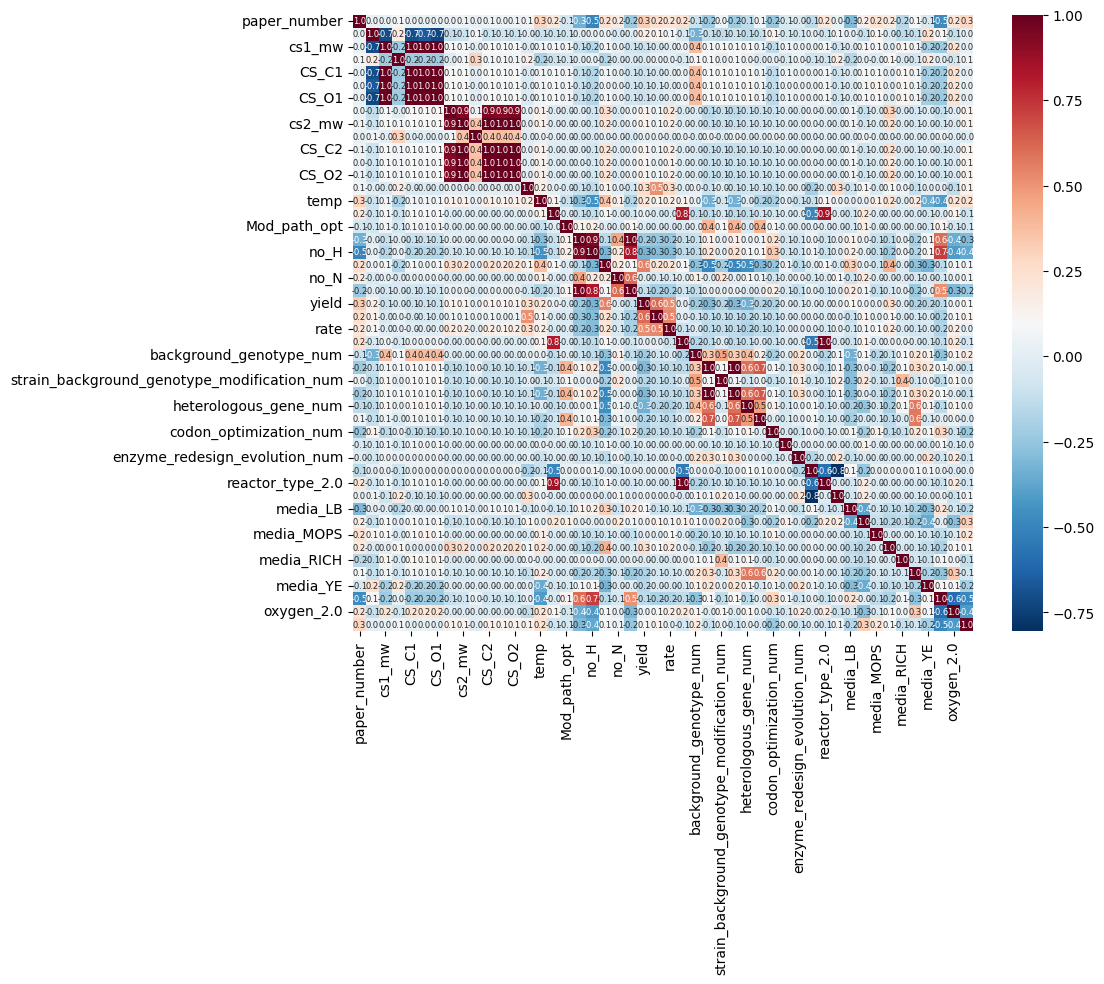

In [56]:
numerical_columns_4 = df_4.select_dtypes(include='number')

plt.figure(figsize=(10, 8))
sns.heatmap(numerical_columns_4.corr(), cmap='RdBu_r', annot=True, fmt='.1f', annot_kws={'size': 6})

<Axes: xlabel='rxt_volume'>

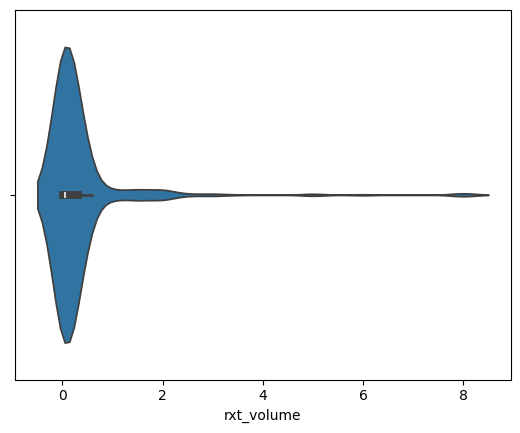

In [62]:
sns.violinplot(x=df['rxt_volume'])

# Model fitting trial 1

## Using df_4 where
1. Lists of genes (e.g. strain_background_genotype_modification, genes_modified) are expressed as number of genes
2. List of numbers for gene details are aggregated by sum e.g. [3,3,3] -> 9
3. Reactor type, media and oxygen have been one-hot encoded

## Further preprocessing
1. To drop cs1 and cs2 (Categorical info would have been captured in cs1_mw and cs2_mw)
2. TO drop all the original gene-related columns (Some information transferred to the summation columns)
3. To drop product_name (Some information in mw. Can represent the product by its molecule class in future e.g. sugar, amino acid)
4. Drop paper number column

# Model: RandomForest or Tree-based models
So that robust against different scales and non-normal distributions

In [63]:
df_trial_1 = df_4.copy()

In [66]:
display(df_trial_1['cs1'].unique())
display(df_trial_1['cs1_mw'].unique())
# Only 5 values of cs1_mw but kept as continuous instead of categorical so that future carbon source can be inserted based on mw

array([ 9.,  1., 13., 12., 15.])

array([ 92.09 , 180.16 , 342.297, 150.13 , 182.17 ])

<Axes: xlabel='cs1_mw', ylabel='Count'>

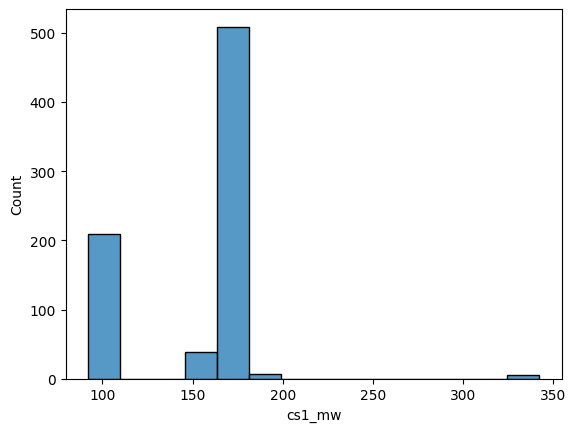

In [69]:
sns.histplot(x=df_trial_1['cs1_mw'])

In [67]:
display(df_trial_1['cs2'].unique())
display(df_trial_1['cs2_mw'].unique())

array([ 0, 12,  6,  5,  1])

array([  0.  , 150.13,  60.05,  87.05, 180.16])

<Axes: xlabel='cs2_mw', ylabel='Count'>

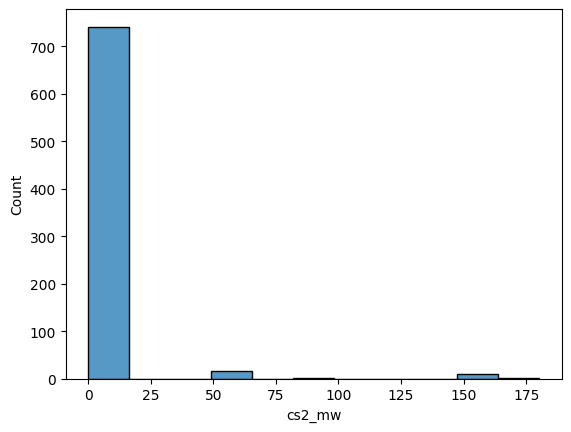

In [70]:
sns.histplot(x=df_trial_1['cs2_mw'])

<Axes: xlabel='cs_conc1'>

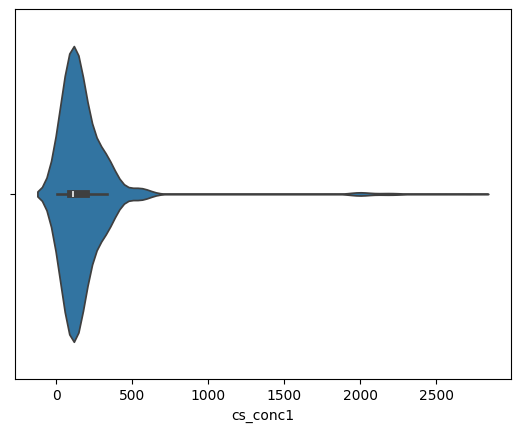

In [71]:
# Not normally distributed. Some outliers on the high side > 2000
sns.violinplot(x=df_trial_1['cs_conc1'])

<Axes: xlabel='cs_conc2'>

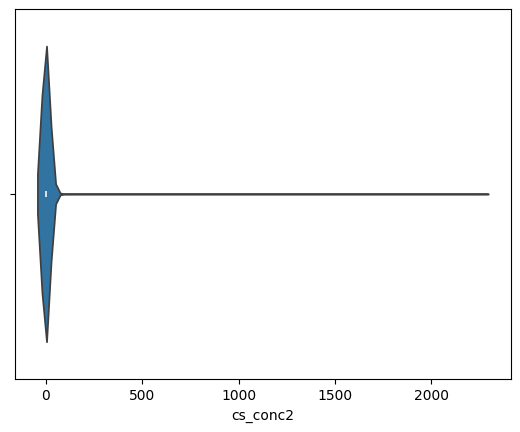

In [72]:
# Not normally distributed. Some outliers on the high side > 2000
sns.violinplot(x=df_trial_1['cs_conc2'])

<Axes: xlabel='CS_O1', ylabel='Count'>

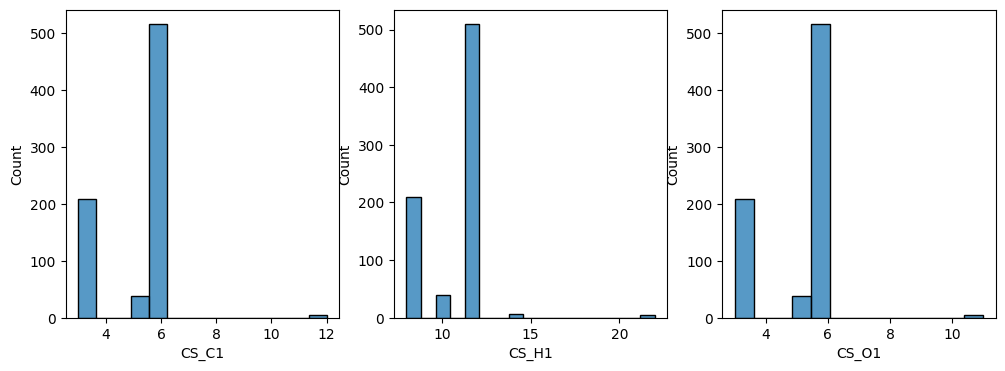

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.histplot(x=df_trial_1['CS_C1'], ax=axes[0])
sns.histplot(x=df_trial_1['CS_H1'], ax=axes[1])
sns.histplot(x=df_trial_1['CS_O1'], ax=axes[2])

<Axes: xlabel='CS_O2', ylabel='Count'>

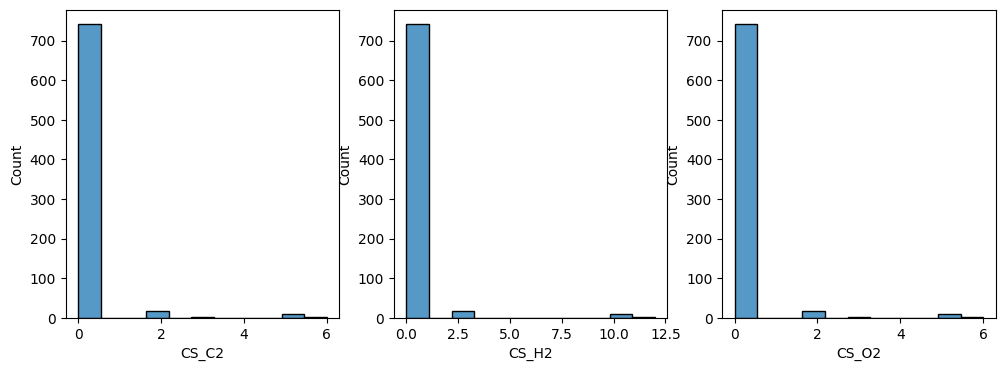

In [81]:
# Mostly zeros
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.histplot(x=df_trial_1['CS_C2'], ax=axes[0])
sns.histplot(x=df_trial_1['CS_H2'], ax=axes[1])
sns.histplot(x=df_trial_1['CS_O2'], ax=axes[2])

<Axes: xlabel='fermentation_time'>

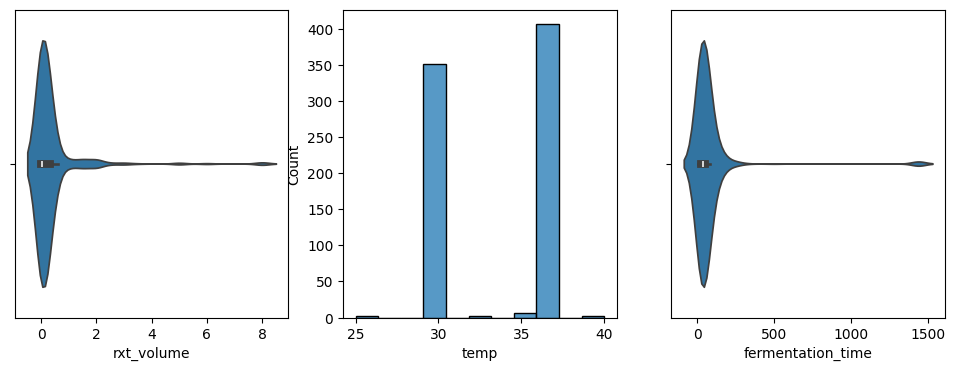

In [83]:
# Some datapoints with 1440 hrs
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.violinplot(x=df_trial_1['rxt_volume'], ax=axes[0])
sns.histplot(x=df_trial_1['temp'], ax=axes[1])
sns.violinplot(x=df_trial_1['fermentation_time'], ax=axes[2])

In [85]:
df_trial_1[df_trial_1.rxt_volume > 6]

,paper_number,cs1,cs1_mw,cs_conc1,CS_C1,CS_H1,CS_O1,cs2,cs2_mw,cs_conc2,CS_C2,CS_H2,CS_O2,rxt_volume,temp,strain_background,strain_background_genotype,strain_background_genotype_modification,genes_modified,gene_deletion,gene_overexpression,heterologous_gene,replication_origin,codon_optimization,sensor_regulator,enzyme_redesign_evolution,protein_scaffold,dir_evo,Mod_path_opt,product_name,no_C,no_H,no_O,no_N,mw,yield,titer,rate,fermentation_time,background_genotype_num,genes_modified_num,strain_background_genotype_modification_num,gene_overexpression_num,heterologous_gene_num,replication_origin_num,codon_optimization_num,sensor_regulator_num,enzyme_redesign_evolution_num,reactor_type_1.0,reactor_type_2.0,reactor_type_3.0,media_LB,media_M9,media_MOPS,media_NBS,media_RICH,media_TB,media_YE,oxygen_1.0,oxygen_2.0,oxygen_3.0
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
653,51,1.0,180.16,277.531083,6.0,12.0,6.0,0,0.00,0.0,0.0,0.0,0.0,8.0,37.0,W3110 (wildtype),"[mcrA, mcrB, rrnD, rrnE]","[0, 0, 0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],0,0,d-lactate,3.0,5.0,3.0,0.0,89.07,0.424636,10.969267,0.228526,48.0,4,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
654,51,1.0,180.16,277.531083,6.0,12.0,6.0,0,0.00,0.0,0.0,0.0,0.0,8.0,37.0,"SZ40 (pflB, frd)","[mcrA, mcrB, rrnD, rrnE, focA, pflB, frdB, frdC]","[0, 0, 0, 0, 0, 0, 0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],0,0,d-lactate,3.0,5.0,3.0,0.0,89.07,1.056146,120.709018,0.628693,192.0,8,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
655,51,1.0,180.16,277.531083,6.0,12.0,6.0,0,0.00,0.0,0.0,0.0,0.0,8.0,37.0,"SZ58 (pflB, frd, adhE)","[mcrA, mcrB, rrnD, rrnE, focA, pflB, frdB, frd...","[0, 0, 0, 0, 0, 0, 0, 0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],0,0,d-lactate,3.0,5.0,3.0,0.0,89.07,1.034369,103.242931,0.716965,144.0,9,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
656,51,1.0,180.16,277.531083,6.0,12.0,6.0,0,0.00,0.0,0.0,0.0,0.0,8.0,37.0,"SZ58 (pflB, frd, adhE; aeration)","[mcrA, mcrB, rrnD, rrnE, focA, pflB, frdB, frd...","[0, 0, 0, 0, 0, 0, 0, 0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],0,0,d-lactate,3.0,5.0,3.0,0.0,89.07,1.001705,25.422336,1.059264,24.0,9,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
657,51,1.0,180.16,277.531083,6.0,12.0,6.0,6,60.05,10.0,2.0,3.0,2.0,8.0,37.0,"SZ58 (pflB, frd, adhE; 10mM sodium acetate)","[mcrA, mcrB, rrnD, rrnE, focA, pflB, frdB, frd...","[0, 0, 0, 0, 0, 0, 0, 0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],0,0,d-lactate,3.0,5.0,3.0,0.0,89.07,1.034369,64.332634,0.893509,72.0,9,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
658,51,1.0,180.16,277.531083,6.0,12.0,6.0,0,0.00,0.0,0.0,0.0,0.0,8.0,37.0,"SZ63 (pflB, frd, adhE, ackA)","[mcrA, mcrB, rrnD, rrnE, focA, pflB, frdB, frd...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],0,0,d-lactate,3.0,5.0,3.0,0.0,89.07,1.045258,14.076442,0.586518,24.0,10,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0


In [84]:
df_trial_1[df_trial_1.fermentation_time > 1000]

,paper_number,cs1,cs1_mw,cs_conc1,CS_C1,CS_H1,CS_O1,cs2,cs2_mw,cs_conc2,CS_C2,CS_H2,CS_O2,rxt_volume,temp,strain_background,strain_background_genotype,strain_background_genotype_modification,genes_modified,gene_deletion,gene_overexpression,heterologous_gene,replication_origin,codon_optimization,sensor_regulator,enzyme_redesign_evolution,protein_scaffold,dir_evo,Mod_path_opt,product_name,no_C,no_H,no_O,no_N,mw,yield,titer,rate,fermentation_time,background_genotype_num,genes_modified_num,strain_background_genotype_modification_num,gene_overexpression_num,heterologous_gene_num,replication_origin_num,codon_optimization_num,sensor_regulator_num,enzyme_redesign_evolution_num,reactor_type_1.0,reactor_type_2.0,reactor_type_3.0,media_LB,media_M9,media_MOPS,media_NBS,media_RICH,media_TB,media_YE,oxygen_1.0,oxygen_2.0,oxygen_3.0
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1110,100,1.0,180.16,11.101243,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.1,37.0,pta-adhE1,"[pta, adhE]","[0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],1,0,l-lactate,3.0,6.0,3.0,0.0,90.0,0.182007,1.66,0.001153,1440.0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
1111,100,1.0,180.16,11.101243,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.1,37.0,pta-adhE2,"[pta, adhE]","[0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],1,0,l-lactate,3.0,6.0,3.0,0.0,90.0,0.187219,1.75,0.001215,1440.0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
1112,100,1.0,180.16,11.101243,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.1,37.0,pta-adhE3,"[pta, adhE]","[0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],1,0,l-lactate,3.0,6.0,3.0,0.0,90.0,0.182586,1.67,0.001160,1440.0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
1113,100,1.0,180.16,11.101243,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.1,37.0,pta-adhE4,"[pta, adhE]","[0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],1,0,l-lactate,3.0,6.0,3.0,0.0,90.0,0.183744,1.69,0.001174,1440.0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
1114,100,1.0,180.16,11.101243,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.1,37.0,pta-adhE5,"[pta, adhE]","[0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],1,0,l-lactate,3.0,6.0,3.0,0.0,90.0,0.182007,1.66,0.001153,1440.0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
1115,100,1.0,180.16,11.101243,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.1,37.0,pta-pfk1,"[pta, pfk]","[0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],1,0,l-lactate,3.0,6.0,3.0,0.0,90.0,0.162313,1.32,0.000917,1440.0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
1116,100,1.0,180.16,11.101243,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.1,37.0,pta-pfk2,"[pta, pfk]","[0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],1,0,l-lactate,3.0,6.0,3.0,0.0,90.0,0.162313,1.32,0.000917,1440.0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
1117,100,1.0,180.16,11.101243,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.1,37.0,pta-pfk3,"[pta, pfk]","[0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],1,0,l-lactate,3.0,6.0,3.0,0.0,90.0,0.162313,1.32,0.000917,1440.0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
1118,100,1.0,180.16,11.101243,6.0,12.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0.1,37.0,pta-adhE-pfk-glk1,"[pta, adhE, pfk, glk]","[0, 0, 0, 0]",[nil],[0],[0],[0],[0],[0],[0],[0],[0],1,0,l-lactate,3.0,6.0,3.0,0.0,90.0,0.162313,1.32,0.000917,1440.0,4,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0


<Axes: xlabel='mw', ylabel='Count'>

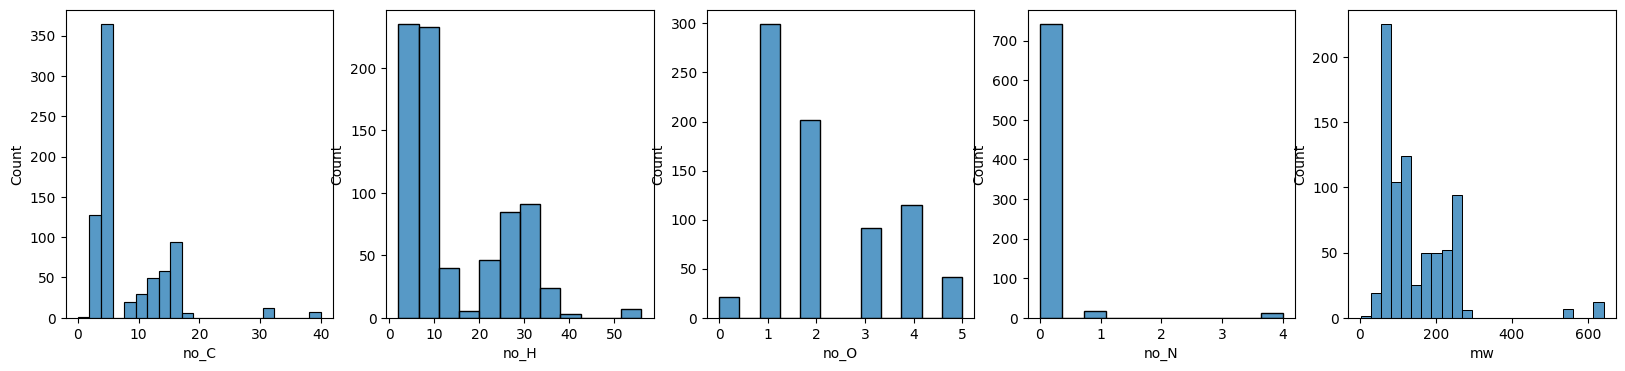

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

sns.histplot(x=df_trial_1['no_C'], ax=axes[0])
sns.histplot(x=df_trial_1['no_H'], ax=axes[1])
sns.histplot(x=df_trial_1['no_O'], ax=axes[2])
sns.histplot(x=df_trial_1['no_N'], ax=axes[3])
sns.histplot(x=df_trial_1['mw'], ax=axes[4])

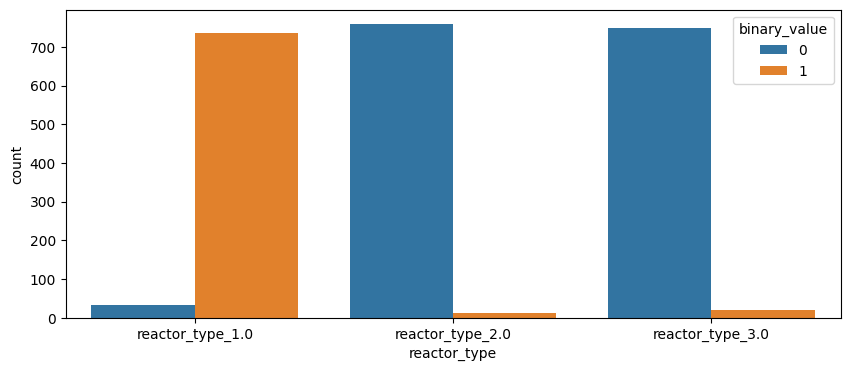

In [90]:
# Plot the one-hot encoded columns

df_reactor_melted = df_trial_1[['reactor_type_1.0', 'reactor_type_2.0', 'reactor_type_3.0']].melt(var_name="reactor_type", value_name="binary_value")

plt.figure(figsize=(10,4))
sns.countplot(data=df_reactor_melted, x="reactor_type", hue="binary_value")
plt.show()

<Axes: xlabel='count', ylabel='media'>

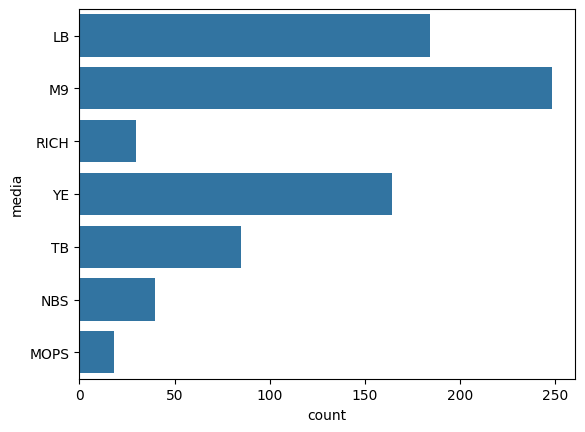

In [93]:
sns.countplot(data=df_1["media"])

<Axes: xlabel='enzyme_redesign_evolution_num', ylabel='Count'>

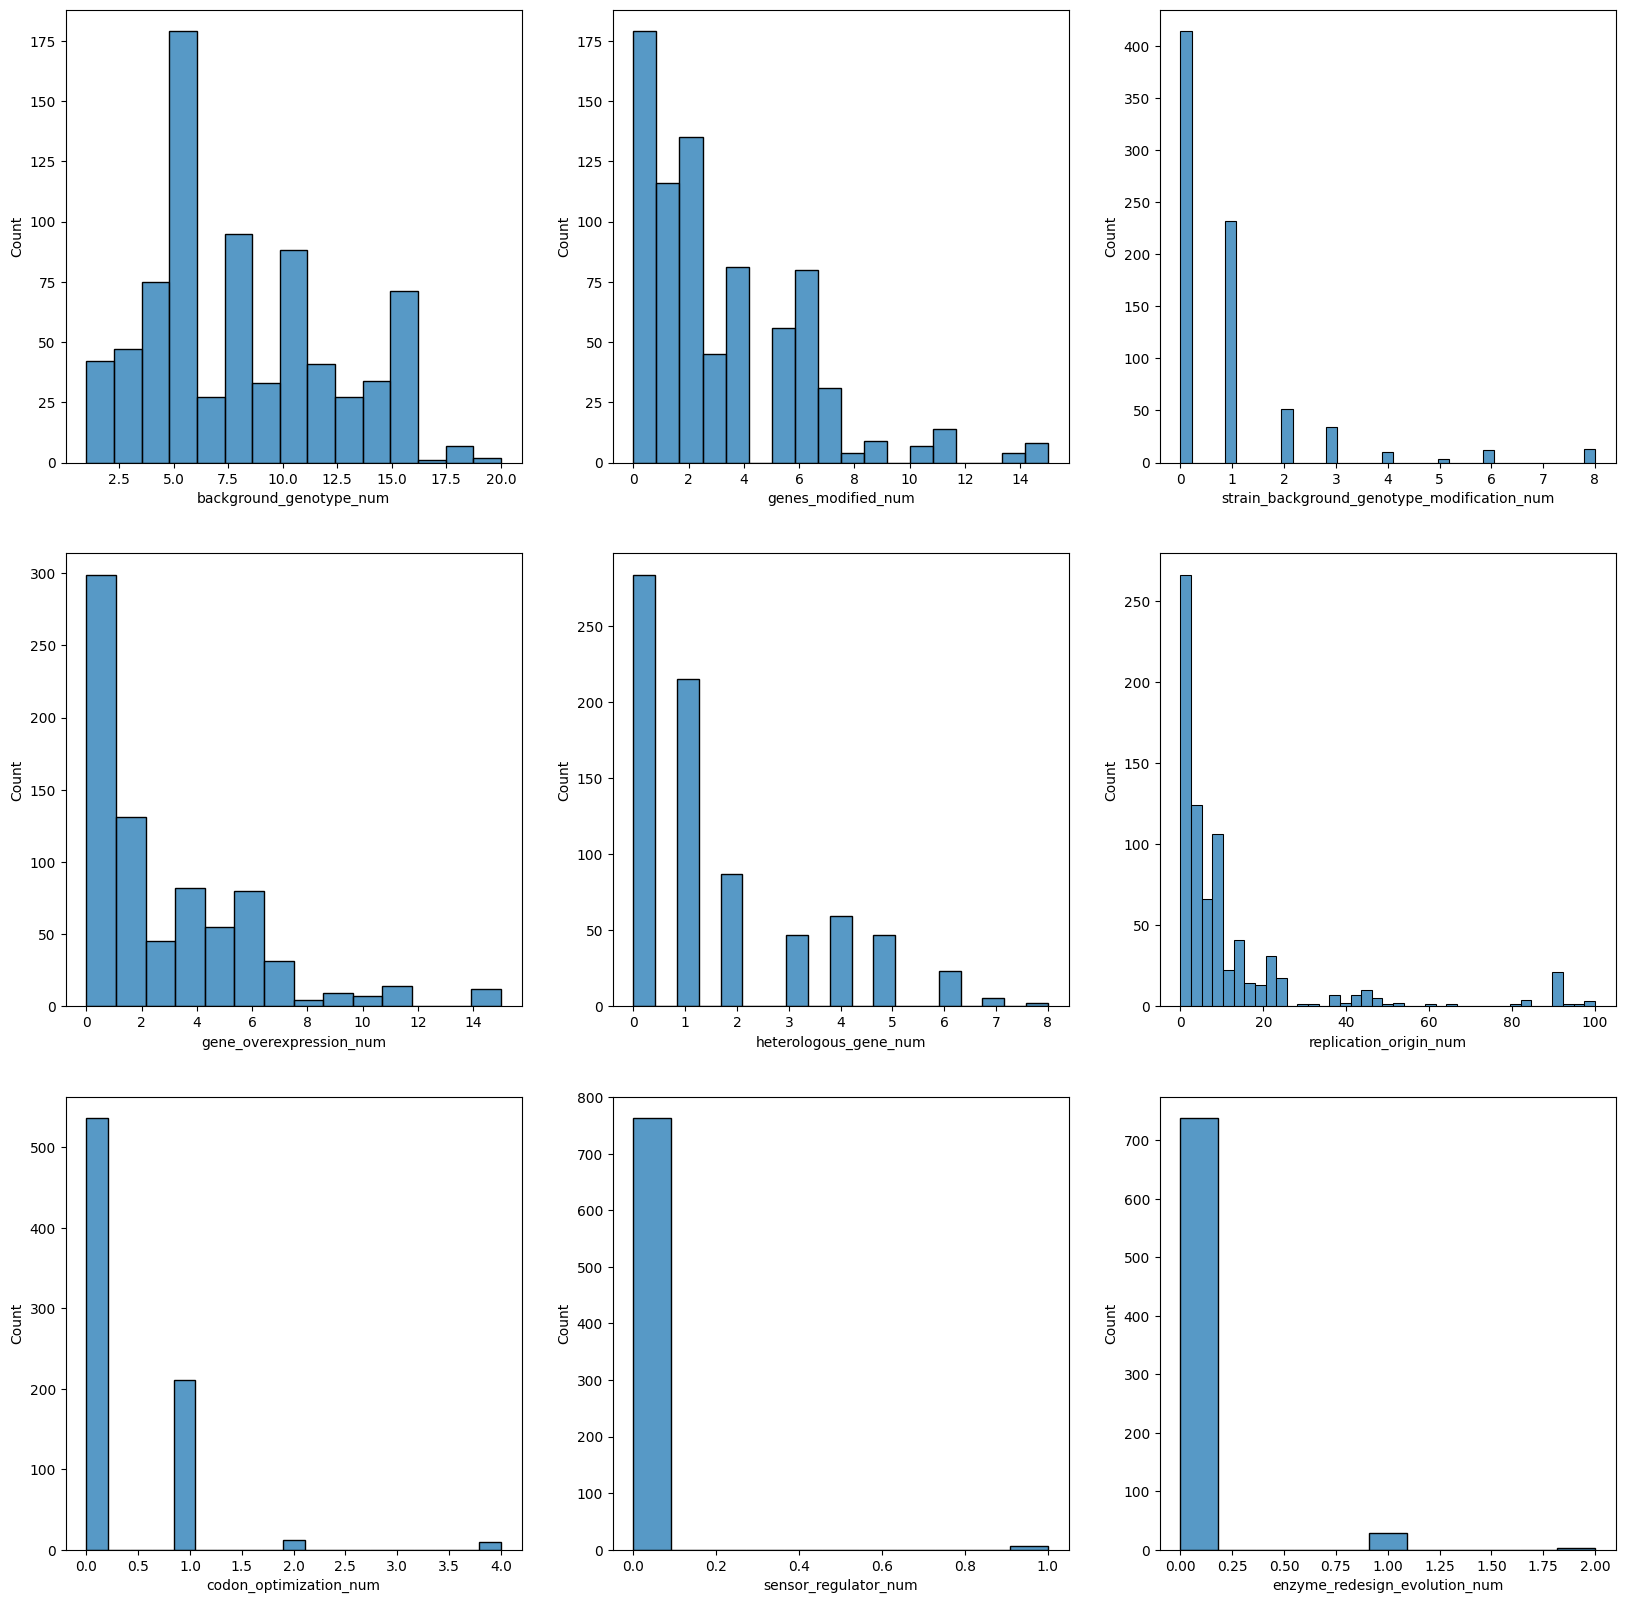

In [98]:
#gene_columns = ['strain_background_genotype_modification', 'gene_overexpression', 'heterologous_gene', 'replication_origin', 'codon_optimization','sensor_regulator', 'enzyme_redesign_evolution']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

sns.histplot(df_trial_1['background_genotype_num'], ax=axes[0][0])
sns.histplot(df_trial_1['genes_modified_num'], ax=axes[0][1])
sns.histplot(df_trial_1['strain_background_genotype_modification_num'], ax=axes[0][2])
sns.histplot(df_trial_1['gene_overexpression_num'], ax=axes[1][0])
sns.histplot(df_trial_1['heterologous_gene_num'], ax=axes[1][1])
sns.histplot(df_trial_1['replication_origin_num'], ax=axes[1][2])
sns.histplot(df_trial_1['codon_optimization_num'], ax=axes[2][0])
sns.histplot(df_trial_1['sensor_regulator_num'], ax=axes[2][1])
sns.histplot(df_trial_1['enzyme_redesign_evolution_num'], ax=axes[2][2])


In [101]:
gene_vs_target_columns = ['background_genotype_num', 'genes_modified_num', 'strain_background_genotype_modification_num', 'gene_overexpression_num', 'heterologous_gene_num', 'replication_origin_num', 'codon_optimization_num','sensor_regulator_num', 'enzyme_redesign_evolution_num', 'yield', 'titer', 'rate']
df_trial_1_geneVStarget = df_trial_1[gene_vs_target_columns]
df_trial_1_geneVStarget.head()

,background_genotype_num,genes_modified_num,strain_background_genotype_modification_num,gene_overexpression_num,heterologous_gene_num,replication_origin_num,codon_optimization_num,sensor_regulator_num,enzyme_redesign_evolution_num,yield,titer,rate
index,,,,,,,,,,,,
0,9,5,3,5,1,1,0,0,0,0.060000,0.936,0.187500
1,4,0,0,0,0,0,0,0,0,0.012011,1.000,0.041667
2,4,2,0,2,2,5,0,0,0,0.016335,1.360,0.028333
3,4,2,0,2,2,5,0,0,0,0.016947,1.411,0.029396
4,4,2,0,2,2,5,1,0,0,0.019818,1.650,0.068750


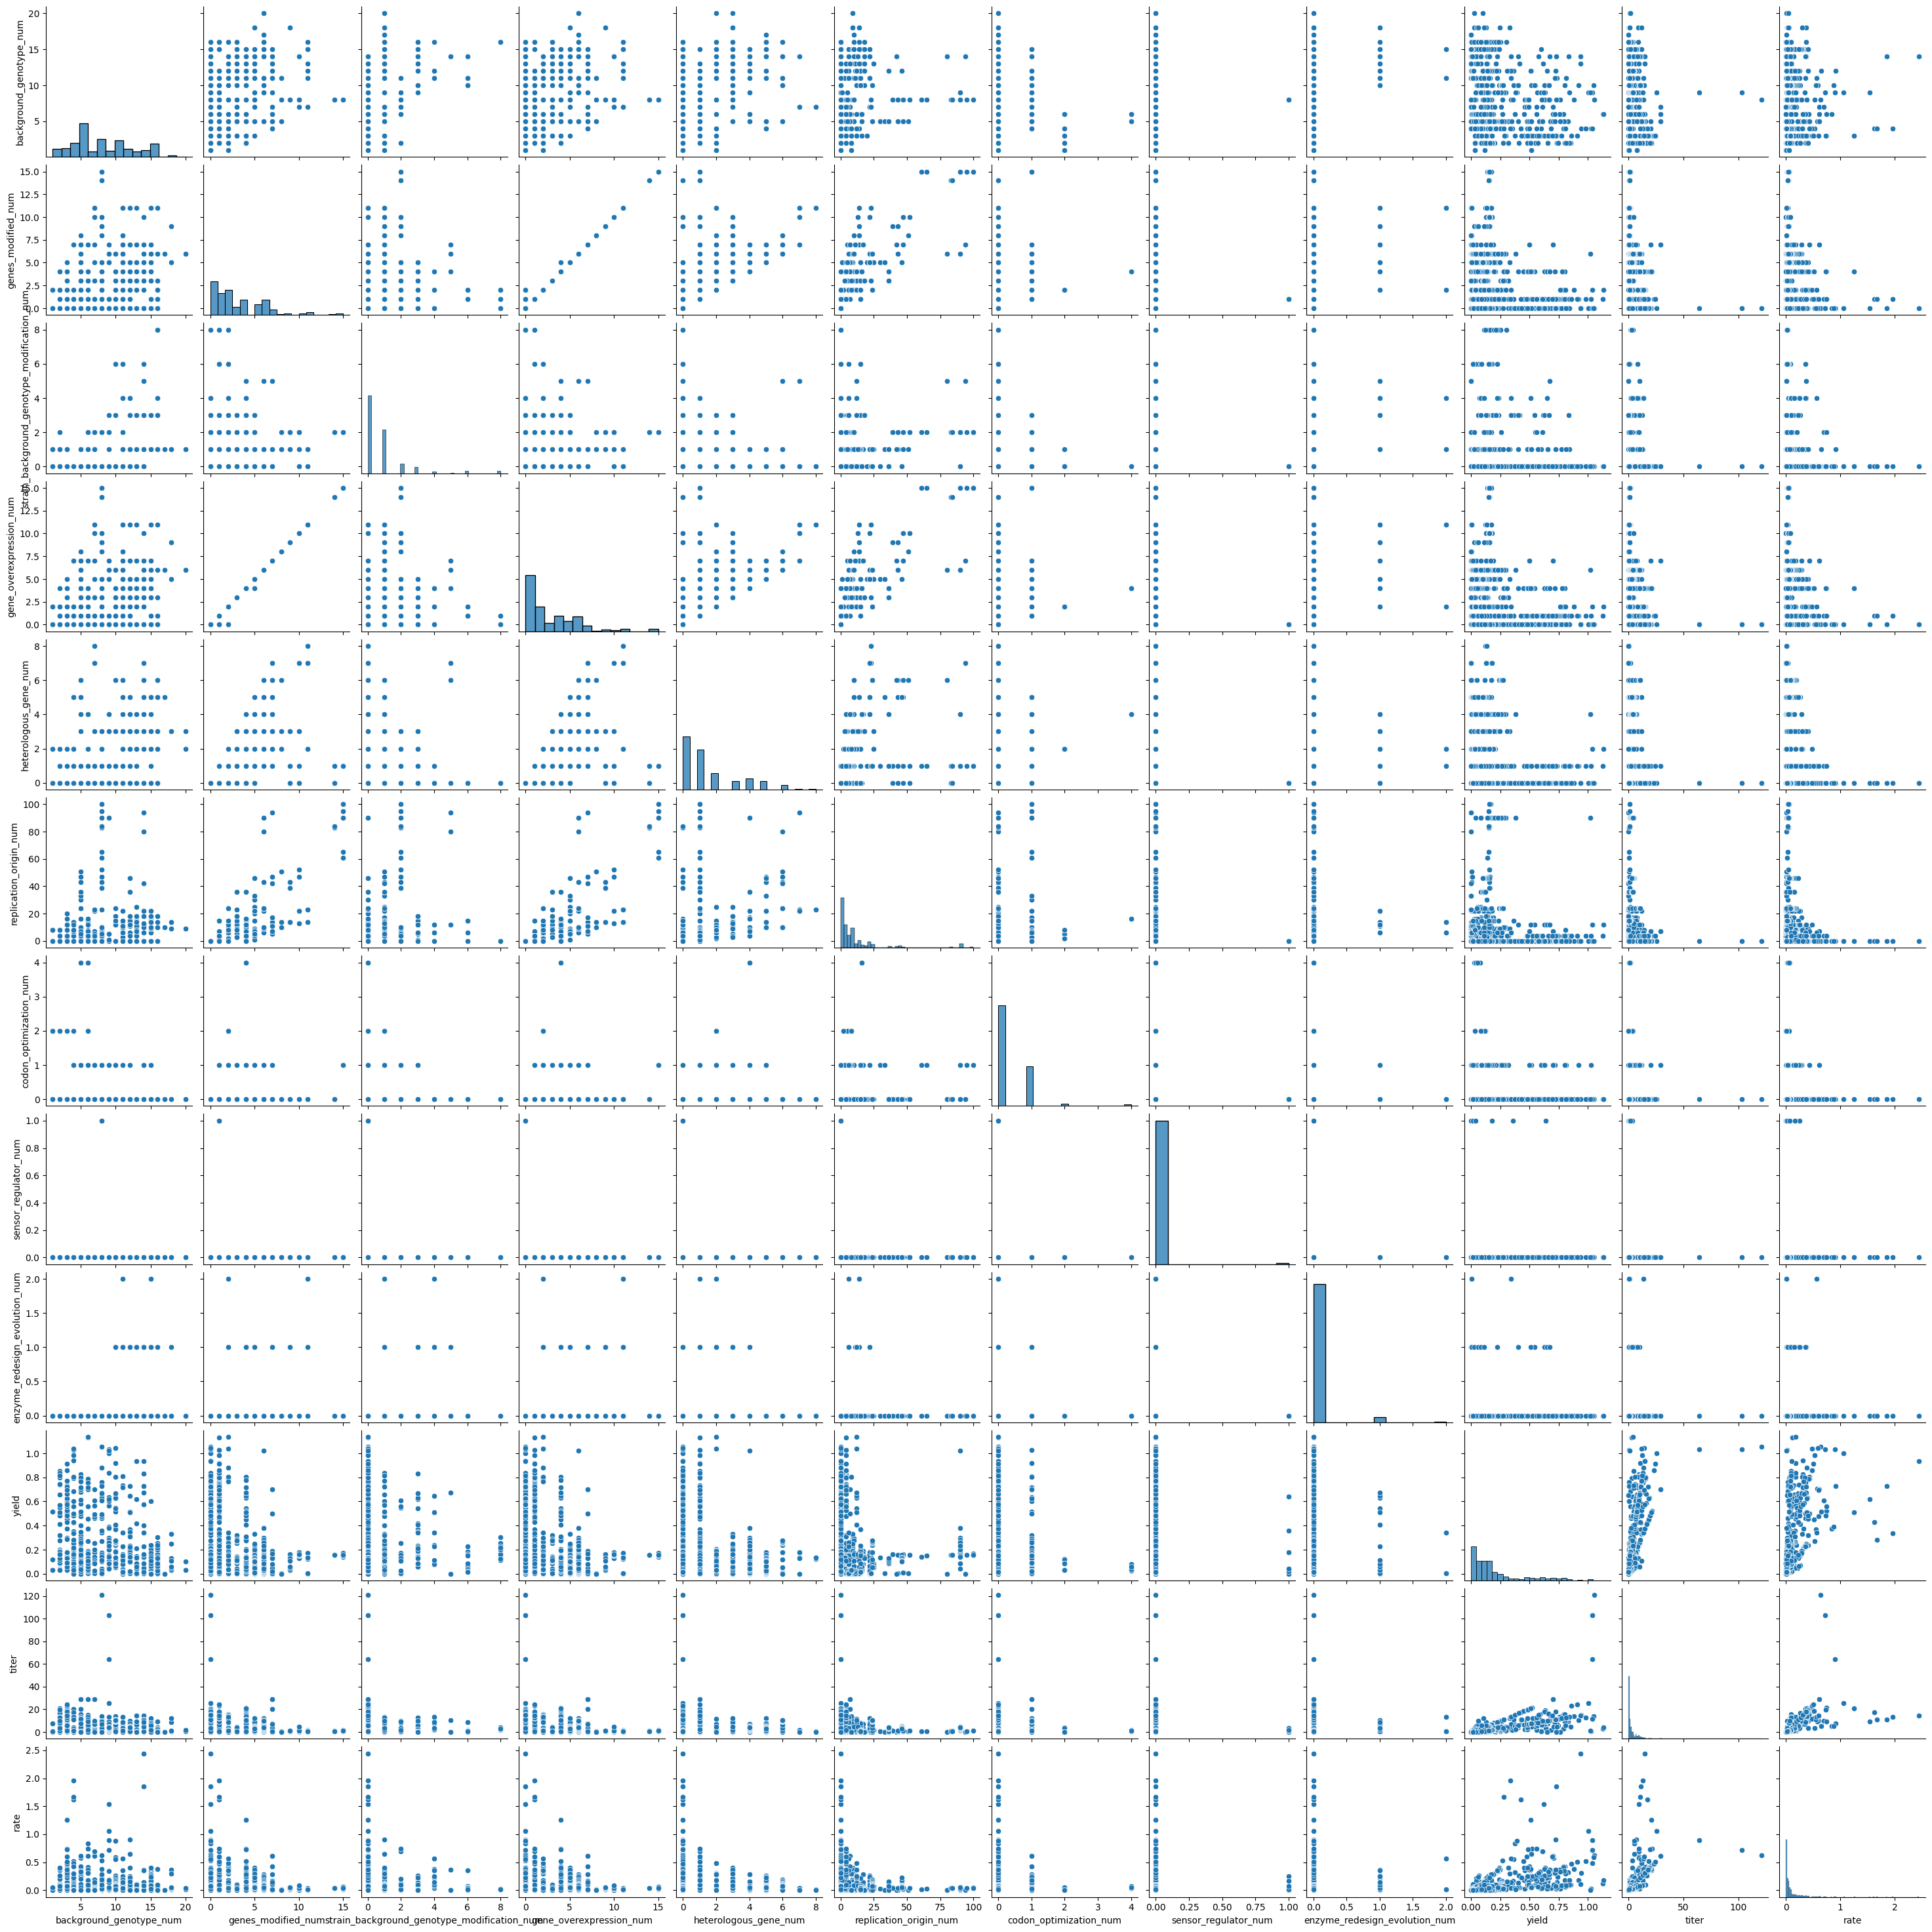

In [102]:
sns.pairplot(df_trial_1_geneVStarget)

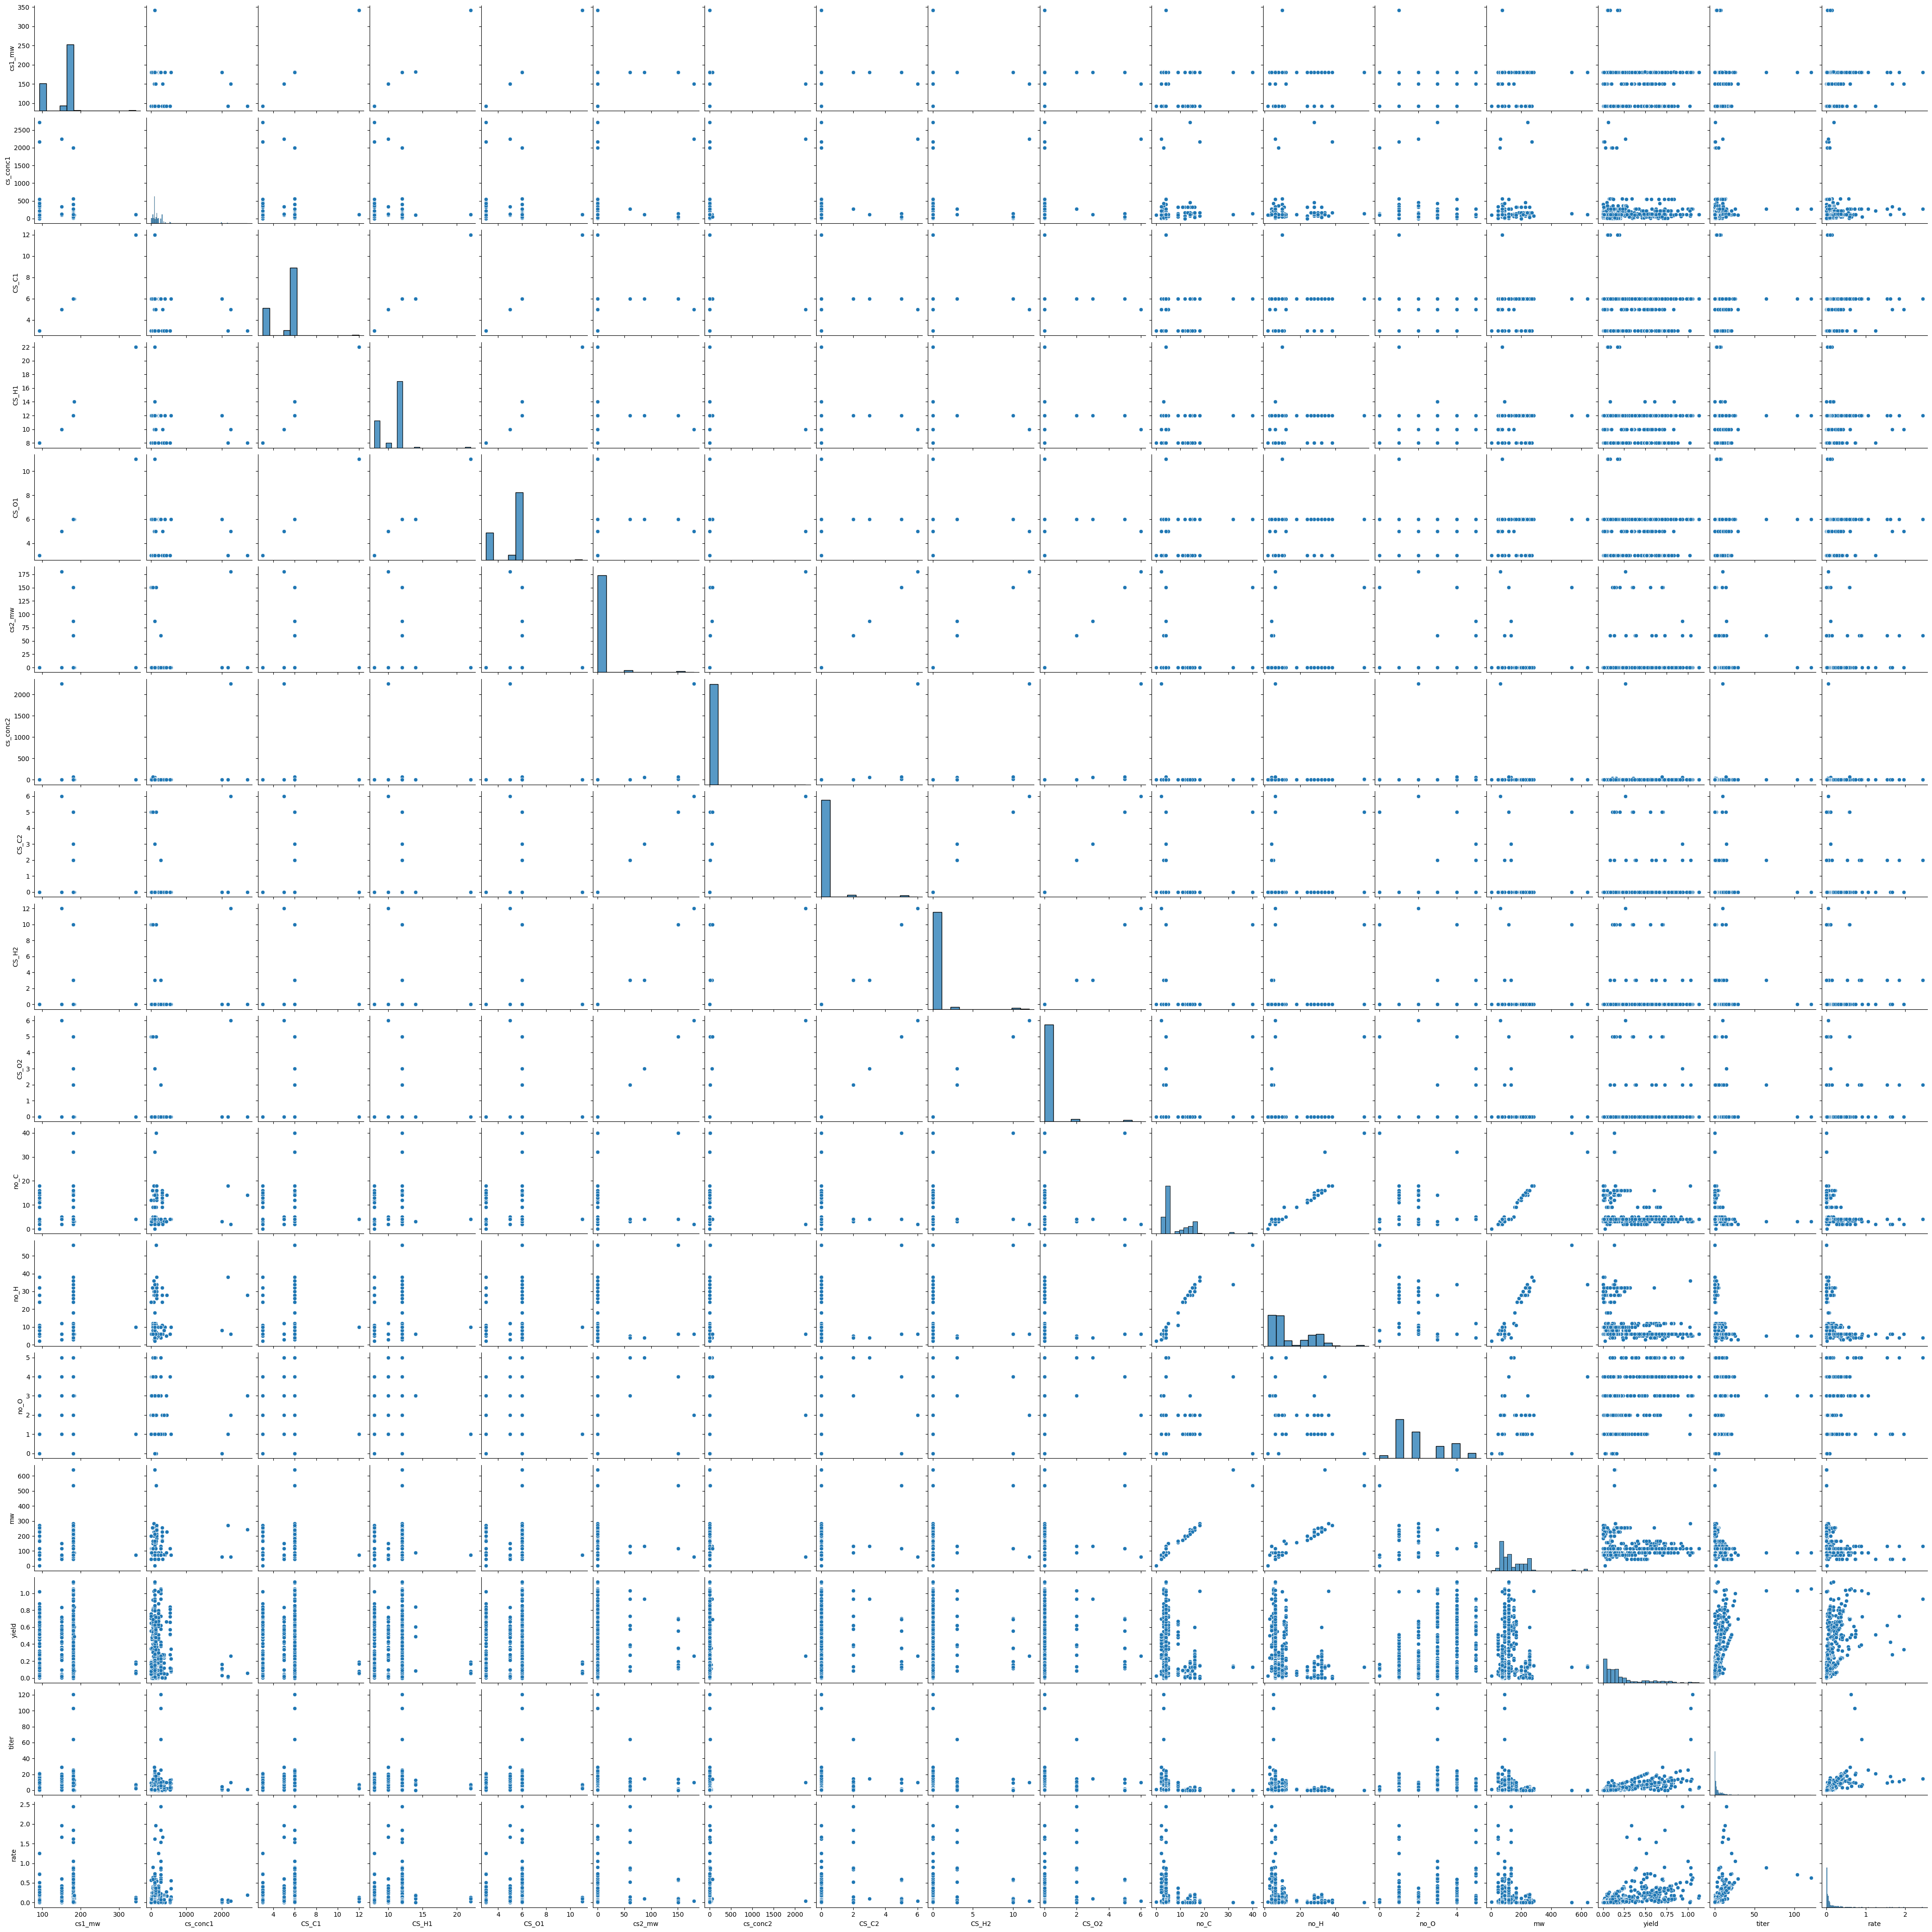

In [103]:
carbon_vs_target_columns = ['cs1_mw', 'cs_conc1', 'CS_C1', 'CS_H1', 'CS_O1', 'cs2_mw', 'cs_conc2', 'CS_C2', 'CS_H2', 'CS_O2', 'no_C', 'no_H', 'no_O', 'mw', 'yield', 'titer', 'rate']

df_trial_1_carbonVStarget = df_trial_1[carbon_vs_target_columns]

sns.pairplot(df_trial_1_carbonVStarget)

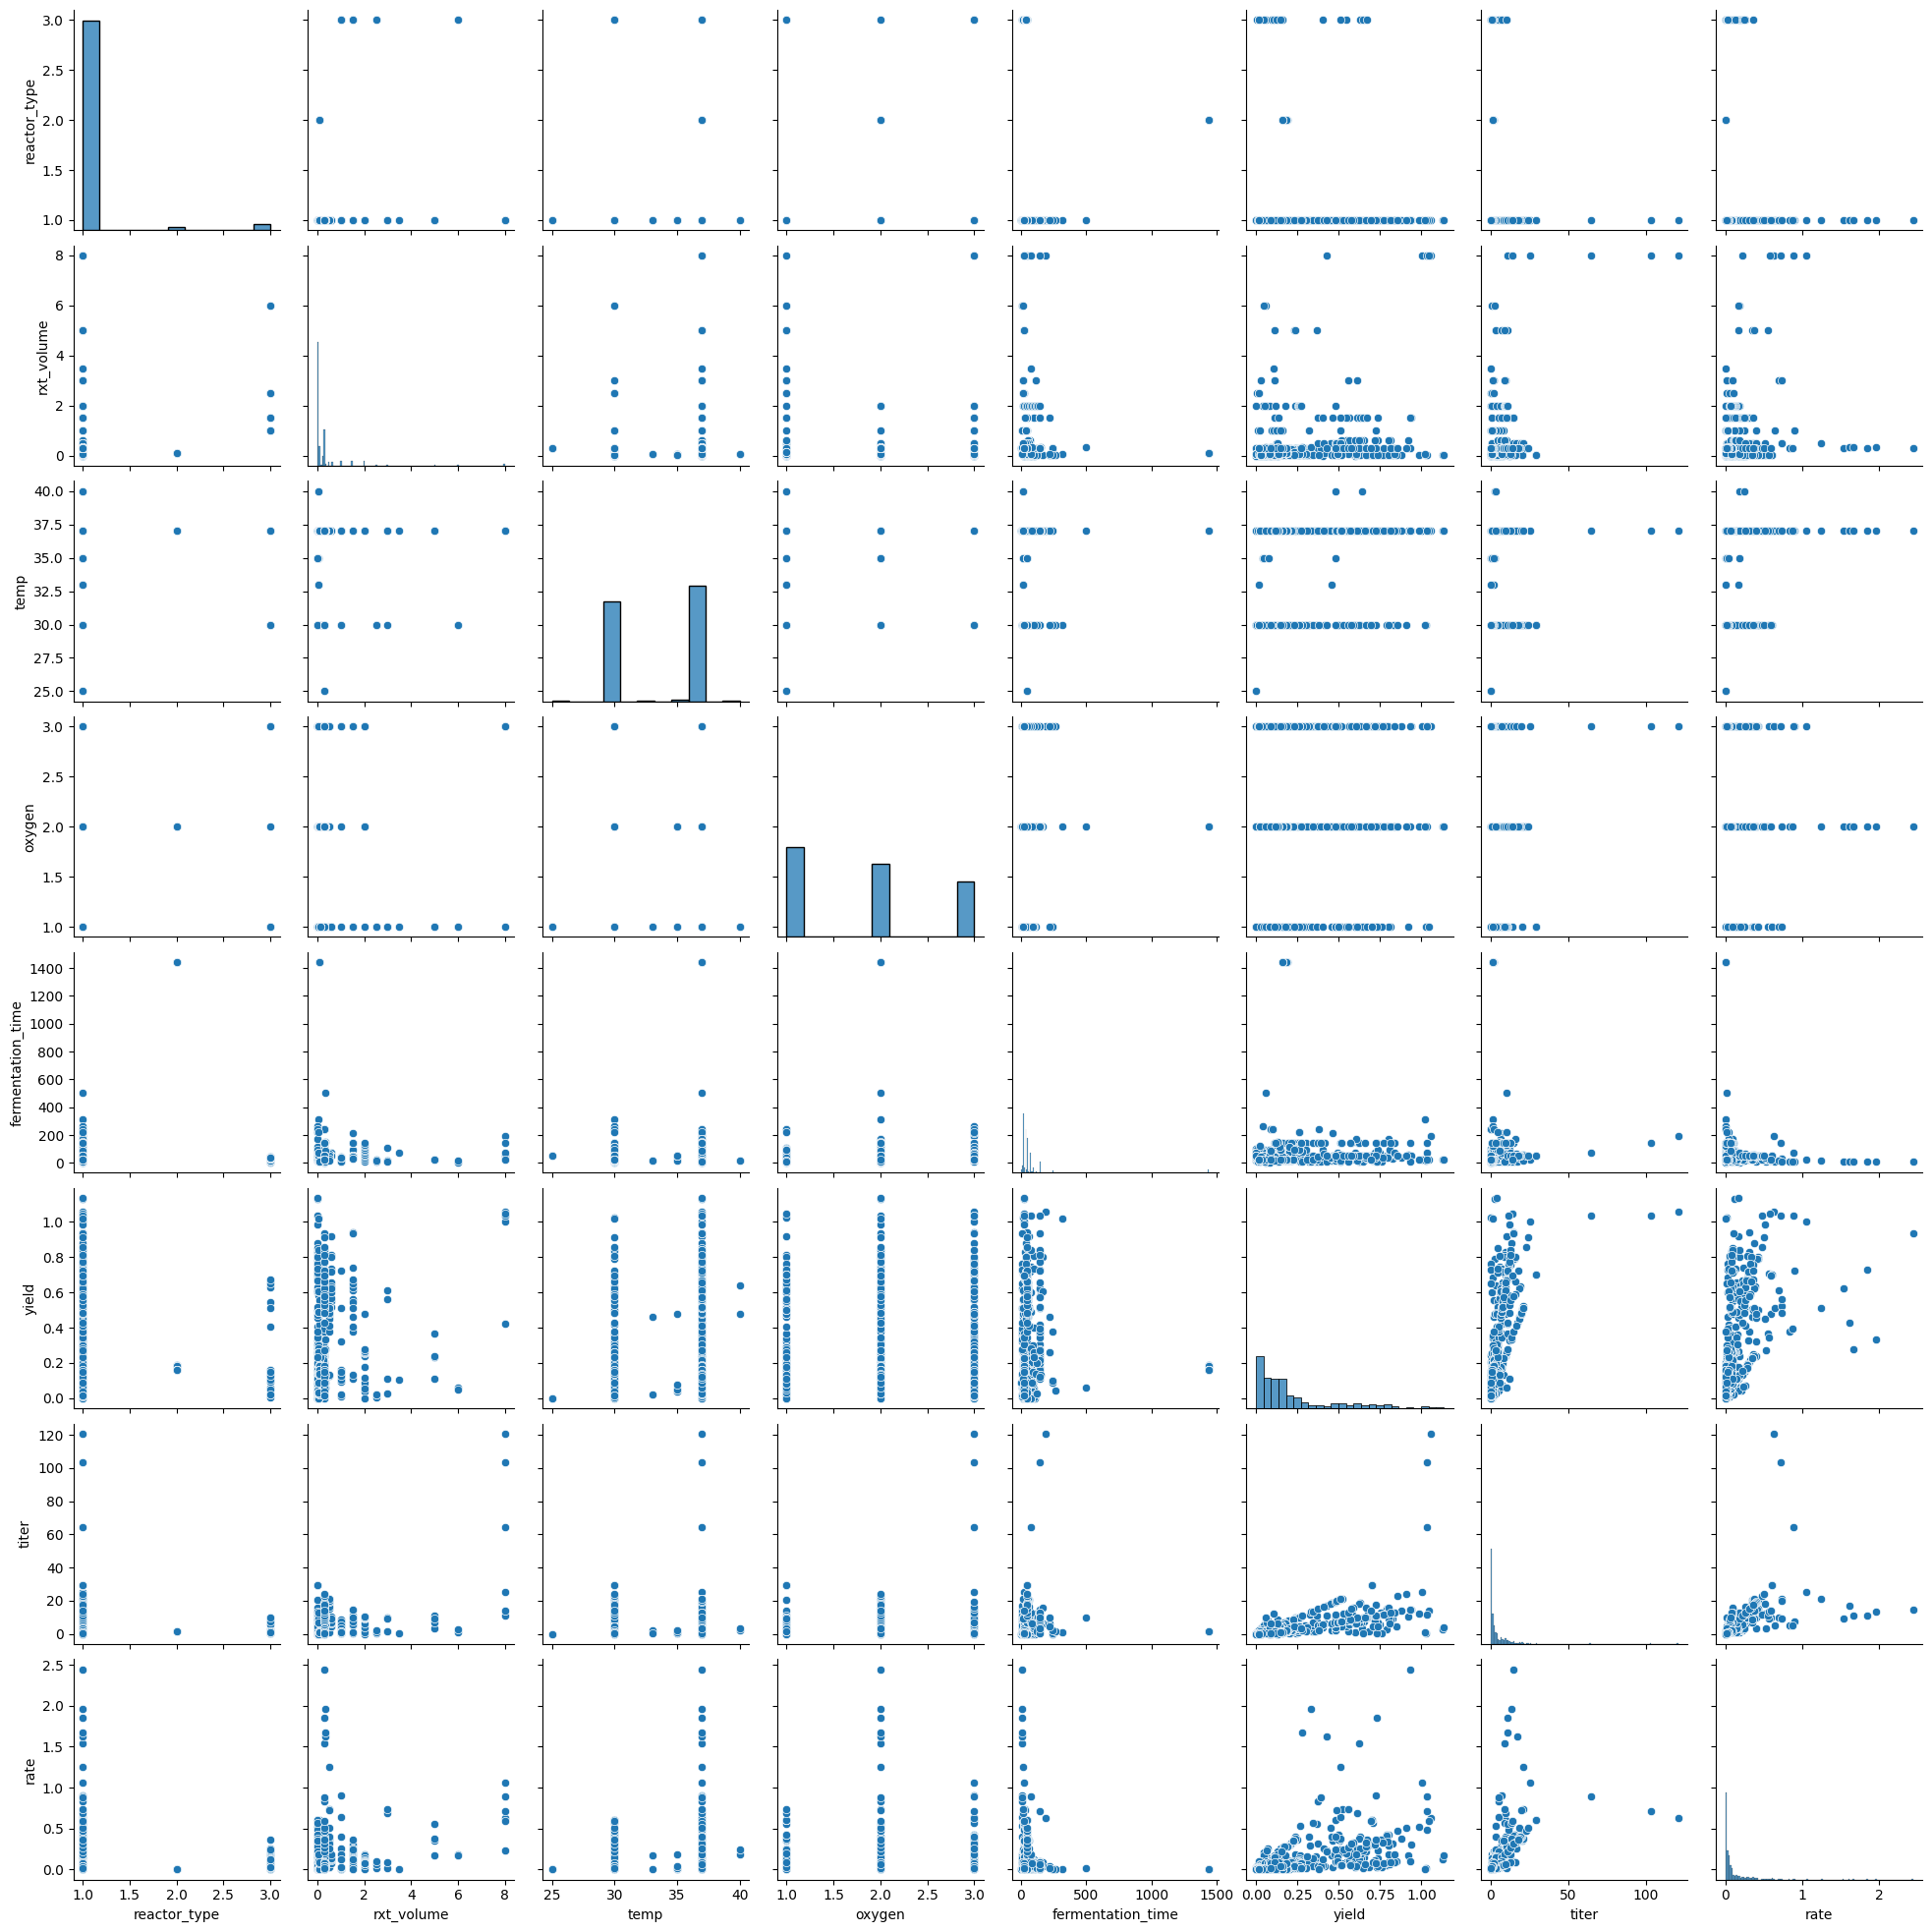

In [104]:
condition_vs_target_columns = ['reactor_type', 'rxt_volume', 'media', 'temp', 'oxygen', 'fermentation_time', 'yield', 'titer', 'rate']
df_trial_1_conditionVStarget = df_1[condition_vs_target_columns]

sns.pairplot(df_trial_1_conditionVStarget)

In [105]:
df_trial_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 769 entries, 0 to 1207
Data columns (total 61 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   paper_number                                 769 non-null    int64  
 1   cs1                                          769 non-null    float64
 2   cs1_mw                                       769 non-null    float64
 3   cs_conc1                                     769 non-null    float64
 4   CS_C1                                        769 non-null    float64
 5   CS_H1                                        769 non-null    float64
 6   CS_O1                                        769 non-null    float64
 7   cs2                                          769 non-null    int64  
 8   cs2_mw                                       769 non-null    float64
 9   cs_conc2                                     769 non-null    float64
 10  CS_C2 

In [106]:
columns_to_drop = ['paper_number', 'cs1', 'cs2', 'strain_background', 'strain_background_genotype', 'strain_background_genotype_modification', 'genes_modified', 'gene_deletion', 'gene_overexpression', 'heterologous_gene', 'replication_origin', 'codon_optimization', 'sensor_regulator', 'enzyme_redesign_evolution', 'protein_scaffold', 'product_name']

df_trial_1b = df_trial_1.drop(columns_to_drop, axis=1)

df_trial_1b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 769 entries, 0 to 1207
Data columns (total 45 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   cs1_mw                                       769 non-null    float64
 1   cs_conc1                                     769 non-null    float64
 2   CS_C1                                        769 non-null    float64
 3   CS_H1                                        769 non-null    float64
 4   CS_O1                                        769 non-null    float64
 5   cs2_mw                                       769 non-null    float64
 6   cs_conc2                                     769 non-null    float64
 7   CS_C2                                        769 non-null    float64
 8   CS_H2                                        769 non-null    float64
 9   CS_O2                                        769 non-null    float64
 10  rxt_vo

In [294]:
df_trial_1b = df_trial_1b.drop(df_trial_1b[df_trial_1b.mw==2].index, axis=0)
df_trial_1b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, 0 to 1207
Data columns (total 45 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   cs1_mw                                       768 non-null    float64
 1   cs_conc1                                     768 non-null    float64
 2   CS_C1                                        768 non-null    float64
 3   CS_H1                                        768 non-null    float64
 4   CS_O1                                        768 non-null    float64
 5   cs2_mw                                       768 non-null    float64
 6   cs_conc2                                     768 non-null    float64
 7   CS_C2                                        768 non-null    float64
 8   CS_H2                                        768 non-null    float64
 9   CS_O2                                        768 non-null    float64
 10  rxt_vo

In [295]:
df_trial_1b_X = df_trial_1b.copy()
df_trial_1b_y = df_trial_1b_X[['yield', 'titer', 'rate']]
df_trial_1b_X = df_trial_1b_X.drop(['yield', 'titer', 'rate'], axis=1)

display(df_trial_1b_X.info())
display(df_trial_1b_y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, 0 to 1207
Data columns (total 42 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   cs1_mw                                       768 non-null    float64
 1   cs_conc1                                     768 non-null    float64
 2   CS_C1                                        768 non-null    float64
 3   CS_H1                                        768 non-null    float64
 4   CS_O1                                        768 non-null    float64
 5   cs2_mw                                       768 non-null    float64
 6   cs_conc2                                     768 non-null    float64
 7   CS_C2                                        768 non-null    float64
 8   CS_H2                                        768 non-null    float64
 9   CS_O2                                        768 non-null    float64
 10  rxt_vo

None

<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, 0 to 1207
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yield   768 non-null    float64
 1   titer   768 non-null    float64
 2   rate    768 non-null    float64
dtypes: float64(3)
memory usage: 24.0 KB


None

In [296]:
X_train, X_test, y_train, y_test = train_test_split(df_trial_1b_X, df_trial_1b_y, test_size=0.3, random_state=11)

In [323]:
rf_rgs = RandomForestRegressor(n_estimators=1500)

rf_rgs.fit(X_train, y_train)

y_pred = rf_rgs.predict(X_test)

In [324]:
y_pred_df = pd.DataFrame(y_pred, columns=['yield', 'titer', 'rate'])

print('R_sqaured score for overall: ', r2_score(y_test, y_pred))
print('R_sqaured score for yield: ', r2_score(y_test['yield'], y_pred_df['yield']))
print('R_sqaured score for titer: ', r2_score(y_test['titer'], y_pred_df['titer']))
print('R_sqaured score for rate: ', r2_score(y_test['rate'], y_pred_df['rate']))
print(" ")
print('RMSE for overall: ', root_mean_squared_error(y_test, y_pred_df))
print('RMSE for yield: ', root_mean_squared_error(y_test['yield'], y_pred_df['yield']))
print('RMSE for titer: ', root_mean_squared_error(y_test['titer'], y_pred_df['titer']))
print('RMSE for rate: ', root_mean_squared_error(y_test['rate'], y_pred_df['rate']))

R_sqaured score for overall:  0.7382940488530751
R_sqaured score for yield:  0.7262280833085675
R_sqaured score for titer:  0.826254046269793
R_sqaured score for rate:  0.6624000169808655
 
RMSE for overall:  1.406389893716784
RMSE for yield:  0.13953153682821684
RMSE for titer:  3.976947265038537
RMSE for rate:  0.10269087928359749


### R_squared improved significantly after removing the datapoint with hydrogen product
But error still about the same as before

In [299]:
y_test.describe()

,yield,titer,rate
count,231.000000,231.000000,231.000000
mean,0.237442,4.387573,0.104053
std,0.267251,9.561688,0.177122
min,0.000000,0.000000,0.000000
25%,0.055650,0.215000,0.004701
50%,0.133514,1.326923,0.031667
75%,0.282124,6.200000,0.103801
max,1.134111,120.709018,1.251639


In [175]:
# No negative values

#y_pred_df

In [321]:
cat_rgs = CatBoostRegressor(n_estimators=1500, loss_function='MultiRMSE', verbose=0)

cat_rgs.fit(X_train, y_train)

y_pred_cat = cat_rgs.predict(X_test)

y_pred_cat = np.maximum(0, y_pred_cat)

In [322]:
y_pred_cat = pd.DataFrame(y_pred_cat, columns=['yield', 'titer', 'rate'])

print('R_sqaured score for overall: ', r2_score(y_test, y_pred_cat))
print('R_sqaured score for yield: ', r2_score(y_test['yield'], y_pred_cat['yield']))
print('R_sqaured score for titer: ', r2_score(y_test['titer'], y_pred_cat['titer']))
print('R_sqaured score for rate: ', r2_score(y_test['rate'], y_pred_cat['rate']))
print(" ")
print('RMSE for overall: ', root_mean_squared_error(y_test, y_pred_cat))
print('RMSE for yield: ', root_mean_squared_error(y_test['yield'], y_pred_cat['yield']))
print('RMSE for titer: ', root_mean_squared_error(y_test['titer'], y_pred_cat['titer']))
print('RMSE for rate: ', root_mean_squared_error(y_test['rate'], y_pred_cat['rate']))



R_sqaured score for overall:  0.7541452494396204
R_sqaured score for yield:  0.7284619371064286
R_sqaured score for titer:  0.9189903547950544
R_sqaured score for rate:  0.6149834564173784
 
RMSE for overall:  0.9880652441171089
RMSE for yield:  0.13896111404202313
RMSE for titer:  2.715569033255082
RMSE for rate:  0.10966558505422143


In [302]:
y_pred_cat.head()

,yield,titer,rate
0,0.010176,1.090667,0.047575
1,0.084338,0.029494,0.001169
2,0.133275,0.267314,0.005217
3,0.087623,0.000000,0.000000
4,0.161905,0.673672,0.000000


In [306]:
y_pred_cat[y_pred_cat['rate']<0]

,yield,titer,rate


In [308]:
y_pred_cat_2 = y_pred_cat.copy()

X_test2 = X_test.copy()

X_test2.reset_index(drop=True, inplace=True)

y_pred_cat_2['rate2'] = y_pred_cat['titer'] / X_test2['fermentation_time']

print('R_squared score for rate: ', r2_score(y_test['rate'], y_pred_cat_2['rate2']))

# Some negative values
#display(y_pred_cat_2)


R_squared score for rate:  -0.47525534004545267


Checking residuals and heteroskedasticity but tree-based models do not assume them.

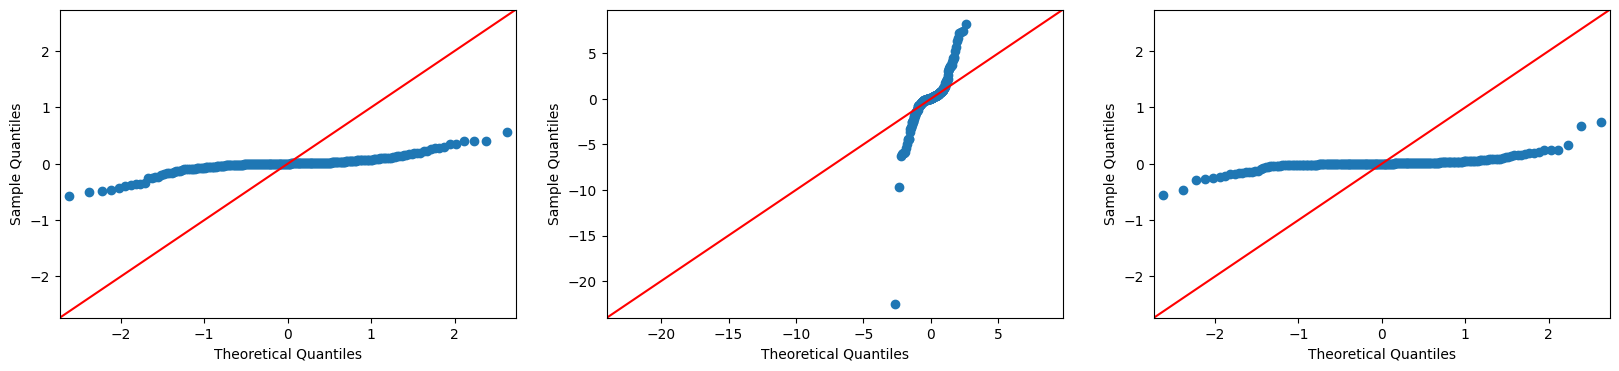

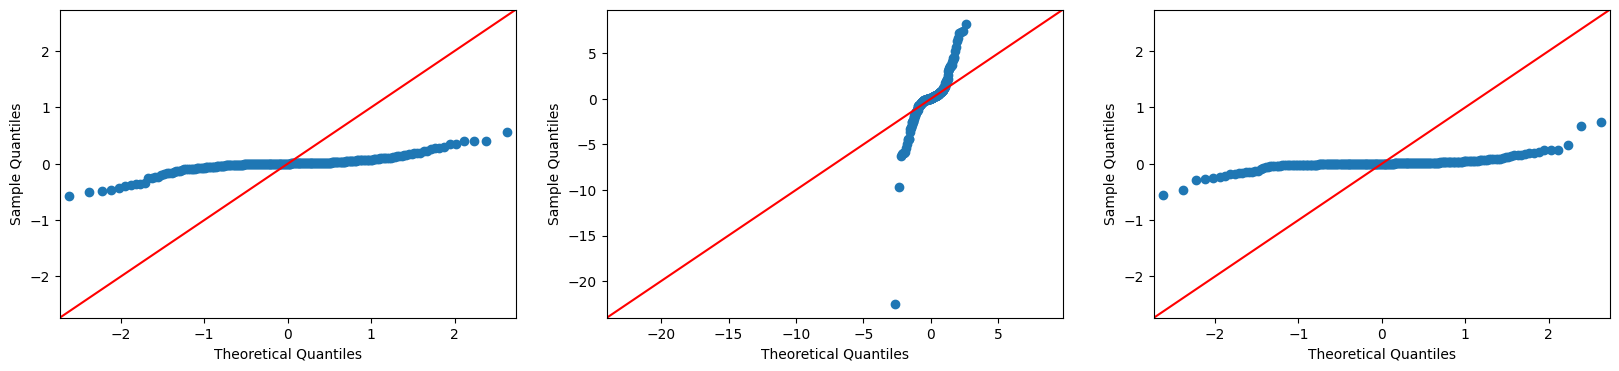

In [340]:
yield_residuals = y_pred_cat['yield'] - y_test['yield']
titer_residuals = y_pred_cat['titer'] - y_test['titer']
rate_residuals = y_pred_cat['rate'] - y_test['rate']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
sm.qqplot(yield_residuals, line='45', ax=axes[0])
sm.qqplot(titer_residuals, line='45', ax=axes[1])
sm.qqplot(rate_residuals, line='45', ax=axes[2])


Text(0.5, 0, 'Predicted')

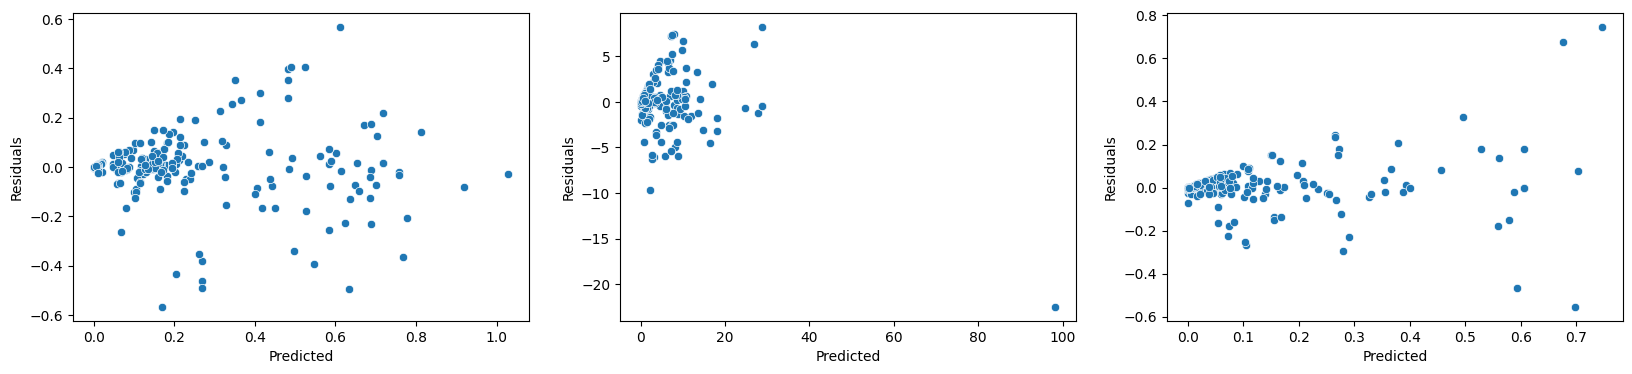

In [343]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
sns.scatterplot(x=y_pred_cat['yield'], y=yield_residuals, ax=axes[0])
axes[0].set_ylabel('Residuals')
axes[0].set_xlabel('Predicted')

sns.scatterplot(x=y_pred_cat['titer'], y=titer_residuals, ax=axes[1])
axes[1].set_ylabel('Residuals')
axes[1].set_xlabel('Predicted')

sns.scatterplot(x=y_pred_cat['rate'], y=rate_residuals, ax=axes[2])
axes[2].set_ylabel('Residuals')
axes[2].set_xlabel('Predicted')

In [327]:
xgb_rgs = XGBRegressor(n_estimators=2000)

xgb_rgs.fit(X_train, y_train)

y_pred_xgb = xgb_rgs.predict(X_test)

In [328]:
y_pred_xgb = pd.DataFrame(y_pred_xgb, columns=['yield', 'titer', 'rate'])
y_test.reset_index(drop=True, inplace=True)
print('R_sqaured score for overall: ', r2_score(y_test, y_pred_xgb))
print('R_sqaured score for yield: ', r2_score(y_test['yield'], y_pred_xgb['yield']))
print('R_sqaured score for titer: ', r2_score(y_test['titer'], y_pred_xgb['titer']))
print('R_sqaured score for rate: ', r2_score(y_test['rate'], y_pred_xgb['rate']))
print(" ")
print('RMSE for overall: ', root_mean_squared_error(y_test, y_pred_xgb))
print('RMSE for yield: ', root_mean_squared_error(y_test['yield'], y_pred_xgb['yield']))
print('RMSE for titer: ', root_mean_squared_error(y_test['titer'], y_pred_xgb['titer']))
print('RMSE for rate: ', root_mean_squared_error(y_test['rate'], y_pred_xgb['rate']))

R_sqaured score for overall:  0.7022569867893275
R_sqaured score for yield:  0.7385148063614353
R_sqaured score for titer:  0.8996628773357087
R_sqaured score for rate:  0.4685932766708386
 
RMSE for overall:  1.0958011088294048
RMSE for yield:  0.1363645490391555
RMSE for titer:  3.022200714456351
RMSE for rate:  0.12883806299270803


In [191]:
display(X_test.shape)

(231, 42)

In [333]:
ada_rgs = AdaBoostRegressor(n_estimators=1500)


multioutput_rgs = MultiOutputRegressor(ada_rgs)
multioutput_rgs.fit(X_train, y_train)

y_pred_ada = multioutput_rgs.predict(X_test)

In [334]:
y_pred_ada = pd.DataFrame(y_pred_ada, columns=['yield', 'titer', 'rate'])
y_test.reset_index(drop=True, inplace=True)
print('R_sqaured score for overall: ', r2_score(y_test, y_pred_ada))
print('R_sqaured score for yield: ', r2_score(y_test['yield'], y_pred_ada['yield']))
print('R_sqaured score for titer: ', r2_score(y_test['titer'], y_pred_ada['titer']))
print('R_sqaured score for rate: ', r2_score(y_test['rate'], y_pred_ada['rate']))
print(" ")
print('RMSE for overall: ', root_mean_squared_error(y_test, y_pred_ada))
print('RMSE for yield: ', root_mean_squared_error(y_test['yield'], y_pred_ada['yield']))
print('RMSE for titer: ', root_mean_squared_error(y_test['titer'], y_pred_ada['titer']))
print('RMSE for rate: ', root_mean_squared_error(y_test['rate'], y_pred_ada['rate']))

R_sqaured score for overall:  0.42679881808673875
R_sqaured score for yield:  0.5086296709887831
R_sqaured score for titer:  0.7873282370851985
R_sqaured score for rate:  -0.015561453813765391
 
RMSE for overall:  1.5883287070906473
RMSE for yield:  0.18693145812724554
RMSE for titer:  4.399946522956054
RMSE for rate:  0.1781081401886421


In [213]:
y_pred_ada.head(50)

,yield,titer,rate
0,0.006946,0.224103,0.007964
1,0.136184,0.899112,0.031379
2,0.127668,0.547384,0.005700
3,0.000769,-0.104949,-0.000307
4,0.262376,3.126681,0.061719
5,0.475134,7.707723,0.190966
6,0.186301,7.397804,0.106007
7,0.670266,10.071293,0.284913
8,0.377254,2.020781,0.157258
9,0.679638,29.011691,0.605210


Concurrent prediction appears better than multioutputregression or regressionchain
CatBoostRegressor appears to be best by R-square but contains negative values. 
RandomForestRegressor has a slightly lower R_sqaure but no negative values

Can try a stacking ensemble or voting classifier

# Try Feature engineering

1. Categorize product_name, one-hot encode and add to data

In [247]:
df_trial_2 = df_trial_1b.copy()

In [248]:
df_trial_2 = pd.concat([df_trial_2, df_1['product_name']], axis=1)
df_trial_2.head()

,cs1_mw,cs_conc1,CS_C1,CS_H1,CS_O1,cs2_mw,cs_conc2,CS_C2,CS_H2,CS_O2,rxt_volume,temp,dir_evo,Mod_path_opt,no_C,no_H,no_O,no_N,mw,yield,titer,rate,fermentation_time,background_genotype_num,genes_modified_num,strain_background_genotype_modification_num,gene_overexpression_num,heterologous_gene_num,replication_origin_num,codon_optimization_num,sensor_regulator_num,enzyme_redesign_evolution_num,reactor_type_1.0,reactor_type_2.0,reactor_type_3.0,media_LB,media_M9,media_MOPS,media_NBS,media_RICH,media_TB,media_YE,oxygen_1.0,oxygen_2.0,oxygen_3.0,product_name
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,92.09,2714.735585,3.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,6.00,30.0,0,0,14.0,28.0,3.0,0.0,244.0,0.060000,0.936,0.187500,4.992,9,5,3,5,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,fatty acid
1,180.16,83.259325,6.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.05,30.0,0,0,12.0,24.0,2.0,0.0,200.0,0.012011,1.000,0.041667,24.000,4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,fatty acid
2,180.16,83.259325,6.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.05,30.0,0,0,12.0,24.0,2.0,0.0,200.0,0.016335,1.360,0.028333,48.000,4,2,0,2,2,5,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,fatty acid
3,180.16,83.259325,6.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.05,30.0,0,0,12.0,24.0,2.0,0.0,200.0,0.016947,1.411,0.029396,48.000,4,2,0,2,2,5,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,fatty acid
4,180.16,83.259325,6.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.05,30.0,0,0,16.0,32.0,2.0,0.0,256.0,0.019818,1.650,0.068750,24.000,4,2,0,2,2,5,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,fatty acid


In [249]:
df_trial_2.product_name.value_counts()

product_name
fatty acid              140
butanol                 131
succinate               103
Isobutanol               61
l-lactate                60
fatty alcohol (odd)      59
fatty alcohol            24
l-malate                 21
xylitol                  20
d-lactate                20
ethanol                  19
l-phenylalanine          15
13PDO                    12
butyrate                  8
methylketone              8
lipid                     7
fatty acid (anteiso)      7
lycopene                  7
glycolate                 7
BDO                       7
PHA                       6
PHB                       6
1-propanol                5
3-Methyl-1-butanol        5
hexanoate                 5
pyruvate                  3
l-alanine                 1
ethylene_glycol           1
hydrogen                  1
Name: count, dtype: int64

In [250]:
# Function to categorize product_name

def categorize_product_name(product):
    if product in ['fatty acid', 'butyrate', 'lipid', 'fatty acid (anteiso)', 'hexanoate']:
        return "fat"
    elif product in ['butanol', 'Isobutanol', 'ethanol', '1-propanol', '3-Methyl-1-butanol ']:
        return "alcohol"
    elif product in ['ethylene_glycol', '13PDO', 'BDO']:
        return 'diol'
    elif product in ['succinate', 'l-lactate', 'l-malate', 'd-lactate', 'glycolate', 'methylketone', 'pyruvate']:
        return 'metabolite'
    elif product in ['fatty alcohol (odd)', 'fatty alcohol']:
        return 'fatty alcohol'
    elif product in ['xylitol']:
        return 'sugar_alcohol'
    elif product in ['l-phenylalanine', 'l-alanine']:
        return 'amino_acid'
    elif product in ['lycopene', 'PHA', 'PHB']:
        return 'large_hydrocarbons'
    elif product in ['hydrogen']:
        return 'hydrogen'

    

In [251]:
df_trial_2['product_category'] = df_trial_2['product_name'].apply(categorize_product_name)

In [253]:
df_trial_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 769 entries, 0 to 1207
Data columns (total 47 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   cs1_mw                                       769 non-null    float64
 1   cs_conc1                                     769 non-null    float64
 2   CS_C1                                        769 non-null    float64
 3   CS_H1                                        769 non-null    float64
 4   CS_O1                                        769 non-null    float64
 5   cs2_mw                                       769 non-null    float64
 6   cs_conc2                                     769 non-null    float64
 7   CS_C2                                        769 non-null    float64
 8   CS_H2                                        769 non-null    float64
 9   CS_O2                                        769 non-null    float64
 10  rxt_vo

In [261]:
df_trial_2['product_category'].value_counts()

product_category
metabolite            222
alcohol               221
fat                   167
fatty alcohol          83
sugar_alcohol          20
diol                   20
large_hydrocarbons     19
amino_acid             16
hydrogen                1
Name: count, dtype: int64

In [262]:
df_trial_2[df_trial_2.product_category == 'hydrogen']

,cs1_mw,cs_conc1,CS_C1,CS_H1,CS_O1,cs2_mw,cs_conc2,CS_C2,CS_H2,CS_O2,rxt_volume,temp,dir_evo,Mod_path_opt,no_C,no_H,no_O,no_N,mw,yield,titer,rate,fermentation_time,background_genotype_num,genes_modified_num,strain_background_genotype_modification_num,gene_overexpression_num,heterologous_gene_num,replication_origin_num,codon_optimization_num,sensor_regulator_num,enzyme_redesign_evolution_num,reactor_type_1.0,reactor_type_2.0,reactor_type_3.0,media_LB,media_M9,media_MOPS,media_NBS,media_RICH,media_TB,media_YE,oxygen_1.0,oxygen_2.0,oxygen_3.0,product_name,product_category
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1072,92.09,108.589423,3.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,0.314546,37.0,0,0,0.0,2.0,0.0,0.0,2.0,0.024976,1.368,0.0114,120.0,7,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,hydrogen,hydrogen


In [288]:
df_trial_2b = df_trial_2.drop(['product_name'], axis=1)
df_trial_2b = df_trial_2b.drop(df_trial_2b[df_trial_2b.product_category=='hydrogen'].index, axis=0)

df_trial_2c = pd.get_dummies(df_trial_2b, columns=['product_category'], prefix='product_category', dtype=int)

In [289]:
df_trial_2c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, 0 to 1207
Data columns (total 53 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   cs1_mw                                       768 non-null    float64
 1   cs_conc1                                     768 non-null    float64
 2   CS_C1                                        768 non-null    float64
 3   CS_H1                                        768 non-null    float64
 4   CS_O1                                        768 non-null    float64
 5   cs2_mw                                       768 non-null    float64
 6   cs_conc2                                     768 non-null    float64
 7   CS_C2                                        768 non-null    float64
 8   CS_H2                                        768 non-null    float64
 9   CS_O2                                        768 non-null    float64
 10  rxt_vo

In [290]:
df_trial_2c_X = df_trial_2c.drop(['yield', 'titer', 'rate'], axis=1)
df_trial_2c_y = df_trial_2c[['yield', 'titer', 'rate']]

X_train2c, X_test2c, y_train2c, y_test2c = train_test_split(df_trial_2c_X, df_trial_2c_y, test_size=0.1, random_state=11)

display(X_train2c.head())
display(X_test2c.head())

,cs1_mw,cs_conc1,CS_C1,CS_H1,CS_O1,cs2_mw,cs_conc2,CS_C2,CS_H2,CS_O2,rxt_volume,temp,dir_evo,Mod_path_opt,no_C,no_H,no_O,no_N,mw,fermentation_time,background_genotype_num,genes_modified_num,strain_background_genotype_modification_num,gene_overexpression_num,heterologous_gene_num,replication_origin_num,codon_optimization_num,sensor_regulator_num,enzyme_redesign_evolution_num,reactor_type_1.0,reactor_type_2.0,reactor_type_3.0,media_LB,media_M9,media_MOPS,media_NBS,media_RICH,media_TB,media_YE,oxygen_1.0,oxygen_2.0,oxygen_3.0,product_category_alcohol,product_category_amino_acid,product_category_diol,product_category_fat,product_category_fatty alcohol,product_category_large_hydrocarbons,product_category_metabolite,product_category_sugar_alcohol
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
212,180.16,111.012433,6.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.005,37.0,0,0,4.0,10.0,1.0,0.0,74.0,24.0,14,4,1,4,3,12,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
481,180.16,199.822380,6.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.020,30.0,0,0,4.0,10.0,1.0,0.0,74.0,40.0,11,7,1,7,2,11,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
586,180.16,16.651865,6.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.100,37.0,0,0,4.0,6.0,4.0,0.0,118.0,72.0,2,1,0,1,0,4,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
196,92.09,54.294712,3.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,0.006,37.0,0,0,4.0,10.0,1.0,0.0,74.0,48.0,5,6,1,6,6,43,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
11,180.16,83.259325,6.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.050,30.0,0,0,12.0,24.0,2.0,0.0,200.0,24.0,4,2,0,2,2,5,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


,cs1_mw,cs_conc1,CS_C1,CS_H1,CS_O1,cs2_mw,cs_conc2,CS_C2,CS_H2,CS_O2,rxt_volume,temp,dir_evo,Mod_path_opt,no_C,no_H,no_O,no_N,mw,fermentation_time,background_genotype_num,genes_modified_num,strain_background_genotype_modification_num,gene_overexpression_num,heterologous_gene_num,replication_origin_num,codon_optimization_num,sensor_regulator_num,enzyme_redesign_evolution_num,reactor_type_1.0,reactor_type_2.0,reactor_type_3.0,media_LB,media_M9,media_MOPS,media_NBS,media_RICH,media_TB,media_YE,oxygen_1.0,oxygen_2.0,oxygen_3.0,product_category_alcohol,product_category_amino_acid,product_category_diol,product_category_fat,product_category_fatty alcohol,product_category_large_hydrocarbons,product_category_metabolite,product_category_sugar_alcohol
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
215,180.16,111.012433,6.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.005,37.0,0,0,4.0,10.0,1.0,0.0,74.00,24.0,14,5,1,5,4,22,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
392,92.09,325.768270,3.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,0.005,30.0,0,0,13.0,28.0,1.0,0.0,200.00,40.0,6,4,1,4,1,7,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0
1000,180.16,111.012433,6.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.100,37.0,0,0,32.0,34.0,4.0,4.0,641.61,48.0,13,3,3,3,3,18,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
667,180.16,50.000000,6.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.100,37.0,0,0,4.0,6.0,4.0,0.0,118.00,80.0,7,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
584,180.16,16.651865,6.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,0.100,37.0,0,0,4.0,6.0,4.0,0.0,118.00,72.0,2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [291]:
rf_rgs_2c = RandomForestRegressor(n_estimators=100)

rf_rgs_2c.fit(X_train2c, y_train2c)

y_pred2c = rf_rgs_2c.predict(X_test2c)

In [335]:
y_pred2c_df = pd.DataFrame(y_pred2c, columns=['yield', 'titer', 'rate'])

print('R_sqaured score for overall: ', r2_score(y_test2c, y_pred2c_df))
print('R_sqaured score for yield: ', r2_score(y_test2c['yield'], y_pred2c_df['yield']))
print('R_sqaured score for titer: ', r2_score(y_test2c['titer'], y_pred2c_df['titer']))
print('R_sqaured score for rate: ', r2_score(y_test2c['rate'], y_pred2c_df['rate']))
print(" ")
print('RMSE for overall: ', root_mean_squared_error(y_test2c, y_pred2c_df))
print('RMSE for yield: ', root_mean_squared_error(y_test2c['yield'], y_pred2c_df['yield']))
print('RMSE for titer: ', root_mean_squared_error(y_test2c['titer'], y_pred2c_df['titer']))
print('RMSE for rate: ', root_mean_squared_error(y_test2c['rate'], y_pred2c_df['rate']))

R_sqaured score for overall:  0.6939942463655483
R_sqaured score for yield:  0.7326294035697154
R_sqaured score for titer:  0.7137448957447377
R_sqaured score for rate:  0.6356084397821917
 
RMSE for overall:  1.2813950731123294
RMSE for yield:  0.15232234854134033
RMSE for titer:  3.5783538529631813
RMSE for rate:  0.11350901783246606


In [16]:
# Function to collect unique genes in strain_background_genotype to form a genotype corpus

def create_corpus(df, feature):
    corpus = set()
    for index, row in df.iterrows():
        corpus.update(row[feature].split(', '))
    return sorted(list(corpus))

In [17]:
genotype_corpus = create_corpus(df_1, 'strain_background_genotype')
genotype_corpus

['HAP-1',
 'KPlpd',
 'T7 RNA polymerase',
 'T7 RNApolymerase',
 'aceA',
 'aceB',
 'aceE',
 'aceF',
 'aceK',
 'ack',
 'ackA',
 'acpS',
 'adh',
 'adhA',
 'adhE',
 'alaD',
 'aldA',
 'alsS',
 'appB',
 'appC',
 'ara',
 'araA',
 'araB',
 'araBAD',
 'araD',
 'arcA',
 'argF',
 'aroB',
 'aroF',
 'aroL',
 'aspA',
 'aspC',
 'atoA',
 'atoC',
 'atoD',
 'atp',
 'cadR',
 'cat',
 'crp',
 'cydA',
 'cydB',
 'cyoA',
 'cyoB',
 'cyoC',
 'cyoD',
 'dcm',
 'deoR',
 'dhaK',
 'dhaL',
 'dhaM',
 'dld',
 'endA',
 'endA1',
 'fabR',
 'fadB',
 'fadD',
 'fadE',
 'fadR',
 'fdhF',
 'fdnG',
 'fnr',
 'fnr ',
 'fnr,ldhA',
 'focA',
 'frd',
 'frdA',
 'frdB',
 'frdBC',
 'frdC',
 'frdD',
 'fucO',
 'fumA',
 'fumB',
 'fumC',
 'gal',
 'galK',
 'galU',
 'gcl',
 'glcB',
 'glcD',
 'gldA',
 'glk',
 'glnV44',
 'glpA',
 'glpX',
 'gltA',
 'gyrA',
 'gyrA96',
 'hsdR',
 'hsdR17',
 'hsdR514',
 'hsdRMS',
 'hsdSb',
 'hycA',
 'icd',
 'iclR',
 'ilvB',
 'ilvC',
 'ilvD',
 'ilvG',
 'ilvI',
 'ind',
 'kivD',
 'kivd',
 'lac',
 'lacA',
 'lacI',
 'lacI